# Airbnb in Amsterdam - Data Cleaning & Exploration 

## Introduction

This project is shown how public data can be used to get meaningful insights. Data was downloaded from insideairbnb.com, using data from Amsterdam. 
The blog about this project can be found here: https://analytics.adapt.nl/?p=3592
and an accompanying Power BI dashboard can be found here: https://klaasjan.eu/airbnb/ 

### Loading modules

First we load some basic modules to make our life easier.

In [1]:
# Importing the required libraries
from datetime import datetime
from collections import OrderedDict
import time
import re
import string
import pandas as pd 
import numpy as np
import geopandas as gpd
import descartes
from scipy.stats import ttest_ind
from shapely.geometry import Polygon
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
# enable jupyter inline plotting
%matplotlib inline
from IPython.display import SVG
print("Done")

Done


### Laden functions

Thanks to Laura Lewis (https://towardsdatascience.com/@lvlewis8) for publishing very useful code that I have slightly edited and expanded. 

In [2]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=82)
    plt.show()
    
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A t-test P-value is calculated.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Mediane prijs ($)')
    ax2.set_xlabel('')
    plt.show()
    
    cat0 = df.loc[df[col] == 0.0].price
    cat1 = df.loc[df[col] == 1.0].price
    tstatistic, pvalue = ttest_ind(cat0, cat1)
    
    cat0_median =(df.loc[df[col] == 0.0].price.median())
    cat1_median = (df.loc[df[col] == 1.0].price.median())
    cat0_count =(df.loc[df[col] == 0.0].price.count())
    cat1_count =(df.loc[df[col] == 1.0].price.count())
    print("")
    print('P-value is %6.2e' % pvalue)
    print("There are " + str(cat0_count) + " without " + str(col) + ", with a median price of " + str(cat0_median))
    print("There are " + str(cat1_count) + " with "  + str(col) + ", with a median price of " + str(cat1_median))

    # Bonferroni correction
    if pvalue < (0.05/106):
        print("Effect is significant!")
    
    df.groupby(col).price
    return pvalue

def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    
#Todo test: zelfde maar rating ipv prijs
def binary_count_and_rating_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
 
    cat0 = df.loc[df[col] == 0.0].price
    cat1 = df.loc[df[col] == 1.0].price
    tstatistic, pvalue = ttest_ind(cat0, cat1)    
    print("")
    
    cat0_median =(df.loc[df[col] == 0.0].review_scores_rating.mean())
    cat1_median = (df.loc[df[col] == 1.0].review_scores_rating.mean())
    cat0_count =(df.loc[df[col] == 0.0].review_scores_rating.count())
    cat1_count =(df.loc[df[col] == 1.0].review_scores_rating.count())
   
    print("There are " + str(cat0_count) + " without " + str(col) + ", with a mean rating of " + str(cat0_median))
    print("There are " + str(cat1_count) + " with "  + str(col) + ", with a mean rating of " + str(cat1_median))
    print('P-value is %6.2e' % pvalue)
    
    # Bonferroni correction
    if pvalue < (0.05/106):
        print("Effect is significant! Here's a plot:")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(col, fontsize=16, y=1)
        plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles

        df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
        ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
        ax1.set_title('Category count')
        ax1.set_xlabel('')

        df.groupby(col).review_scores_rating.mean().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
        ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
        ax2.set_title('Rating')
        ax2.set_xlabel('')
        plt.show()
    
    df.groupby(col).review_scores_rating
    return pvalue

# Loading data

The data at airbnb.com is continuously updating. To ensure reproducibility, I put a _freeze_ of a download on my own server. 

In [3]:
# load data
raw_df = pd.read_csv("https://klaasjan.eu/files/airbnb/listings_detailed.csv.gz", low_memory=False)
print(f"The dataset contains {len(raw_df)} Airbnb listings")

# Set pandas max columns to number of columns in data
pd.set_option('display.max_columns', len(raw_df.columns)) 
pd.set_option('display.max_rows', 110) 
raw_df.head()

The dataset contains 20025 Airbnb listings


id                         listing_url       scrape_id last_scraped  \
0   2818   https://www.airbnb.com/rooms/2818  20191207212953   2019-12-08   
1  20168  https://www.airbnb.com/rooms/20168  20191207212953   2019-12-08   
2  25428  https://www.airbnb.com/rooms/25428  20191207212953   2019-12-08   
3  27886  https://www.airbnb.com/rooms/27886  20191207212953   2019-12-08   
4  28871  https://www.airbnb.com/rooms/28871  20191207212953   2019-12-08   

                                                name  \
0           Quiet Garden View Room & Super Fast WiFi   
1       Studio with private bathroom in the centre 1   
2    Lovely apt in City Centre (w.lift) near Jordaan   
3  Romantic, stylish B&B houseboat in canal district   
4                            Comfortable double room   

                                             summary  \
0           Quiet Garden View Room & Super Fast WiFi   
1  17th century Dutch townhouse in the heart of t...   
2                                                NaN   
3  Stylish and romantic houseboat on fantastic hi...   
4                                                NaN   

                                               space  \
0  I'm renting a bedroom (room overlooking the ga...   
1  For those who like all facets of city life. In...   
2  This nicely furnished, newly renovated apt  is...   
3  For a romantic couple: A beautifully restored ...   
4  In a monumental house right in the center of A...   

                                         description experiences_offered  \
0  Quiet Garden View Room & Super Fast WiFi I'm r...                none   
1  17th century Dutch townhouse in the heart of t...                none   
2  This nicely furnished, newly renovated apt  is...                none   
3  Stylish and romantic houseboat on fantastic hi...                none   
4  In a monumental house right in the center of A...                none   

                               neighborhood_overview  \
0  Indische Buurt ("Indies Neighborhood") is a ne...   
1  Located just in between famous central canals....   
2                                                NaN   
3         Central, quiet, safe, clean and beautiful.   
4                                                NaN   

                                               notes  \
0  From week 38 to week 47 maintenance work to th...   
1  Check-in time from 2pm till 10pm (But it doesn...   
2                                                NaN   
3  we have a canadian canoe for you as well, free...   
4  Washing and drying are for a flat fee of €15 p...   

                                             transit  \
0  The neighbourhood is well served by 24 hours p...   
1  No need to use any transport! All is within a ...   
2  The number 17 and #13 tram stop right outside ...   
3  cental station aprox. 10 minutes on foot, buss...   
4                                                NaN   

                                              access  \
0                                                NaN   
1                                                NaN   
2  The apartment is about 75 meters or 800 square...   
3                 Your own apartment, nothing shared   
4                                                NaN   

                                         interaction  \
0                                                NaN   
1  No curfew, free entrance 27/7 with your own ke...   
2  However, our good friends who live close by ta...   
3  As much as they want, and is possible. I speak...   
4                                                NaN   

                                         house_rules  thumbnail_url  \
0  Please: - Leave your shoes in the entrance  - ...            NaN   
1  This studio/room takes entire floor and has it...            NaN   
2  The building is a quiet building, so please do...            NaN   
3  All the facilities  are included ( cleaning , ...            NaN   
4                                  

## Cleaning data

### Deleting unnecessary columns

Columns that don't add any useful information can be removed (like URL, country or city). 

In [4]:
# Drop columns that are unnecessary or with too many missing values
print(f"The dataset contains {len(raw_df)} Airbnb listings")
#cols_to_drop = ['id','listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered','neighborhood_overview','notes','transit','access','interaction','house_rules','thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'calculated_host_listings_count','latitude','longitude','host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped','host_response_time','host_response_rate','host_acceptance_rate','neighbourhood_group_cleansed','square_feet','license','weekly_price',]
#raw_df.drop(cols_to_drop, axis=1, inplace = True)
cols_to_drop = ['id','listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered','street','neighborhood_overview','notes','transit','access','interaction','house_rules','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url', 'host_name','calculated_host_listings_count','host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped','host_acceptance_rate','neighbourhood_group_cleansed','square_feet','license','weekly_price','monthly_price','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','jurisdiction_names','maximum_nights_avg_ntm','calendar_updated','neighbourhood','city','state','zipcode','market','smart_location','country_code','country','number_of_reviews_ltm','reviews_per_month','has_availability','availability_30','availability_60','availability_90','host_has_profile_pic','require_guest_profile_picture','has_availability','is_business_travel_ready','require_guest_phone_verification','requires_license','is_location_exact']
cols_to_drop
df = raw_df.drop(cols_to_drop, axis=1)
print(f"The dataset contains {len(df)} Airbnb listings")
df.isna().sum()
df.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace = True)
print(raw_df.isna().sum())

The dataset contains 20025 Airbnb listings
The dataset contains 20025 Airbnb listings
id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                               34
summary                                           635
space                                            5371
description                                       242
experiences_offered                                 0
neighborhood_overview                            6384
notes                                           11636
transit                                          6103
access                                           8691
interaction                                      7931
house_rules                                      7810
thumbnail_url                                   20025
medium_url                                      20

### Dealing with missing data

Some data is missing in the Airbnb dataset. Not every listing has information on the number of available beds, or for how long a host has been registered. Some values are essential, which means we have to exclude some listings from the dataset. 
In some cases we an deal with missing data in another way. In case of a missing value for 'cleaning costs', we can assume this value should be zero. For other values we can introduce a category 'unknown', or replace the missing data with the median of the column. This will be determined for each column with missing values separately.

In [5]:
# Number of missing values per column
df.isna().sum()

host_since                                       158
host_response_time                              9349
host_response_rate                              9349
host_is_superhost                                158
host_listings_count                              158
host_total_listings_count                        158
host_identity_verified                           158
neighbourhood                                      0
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                          6
bedrooms                                          13
beds                                              31
bed_type                                           0
amenities                                          0
price                                         

### Miscellaneous data wrangling

In [6]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Convert prices from string to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['security_deposit'] = df['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
df['extra_people'] = df['extra_people'].replace('[\$,]', '', regex=True).astype(float)
df['cleaning_fee'] = df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
print(f"The dataset contains {len(df)} Airbnb listings")

The dataset contains 20025 Airbnb listings


### Initial data explorations

- Many listings have rating of either 9 or 10. 
- The number of bathrooms is usually 0, but sometimes it is 1.5 (which means we can not assume this value is always a whole number).
- There are a couple for very large accomodations, suitable for groups of more than 10 people
- A minority of hosts is a 'superhost'
- Most accomodations have a listing price between 50 and 200 dollars, but there are a couple of outliers that cost a couple thousand dollars a night


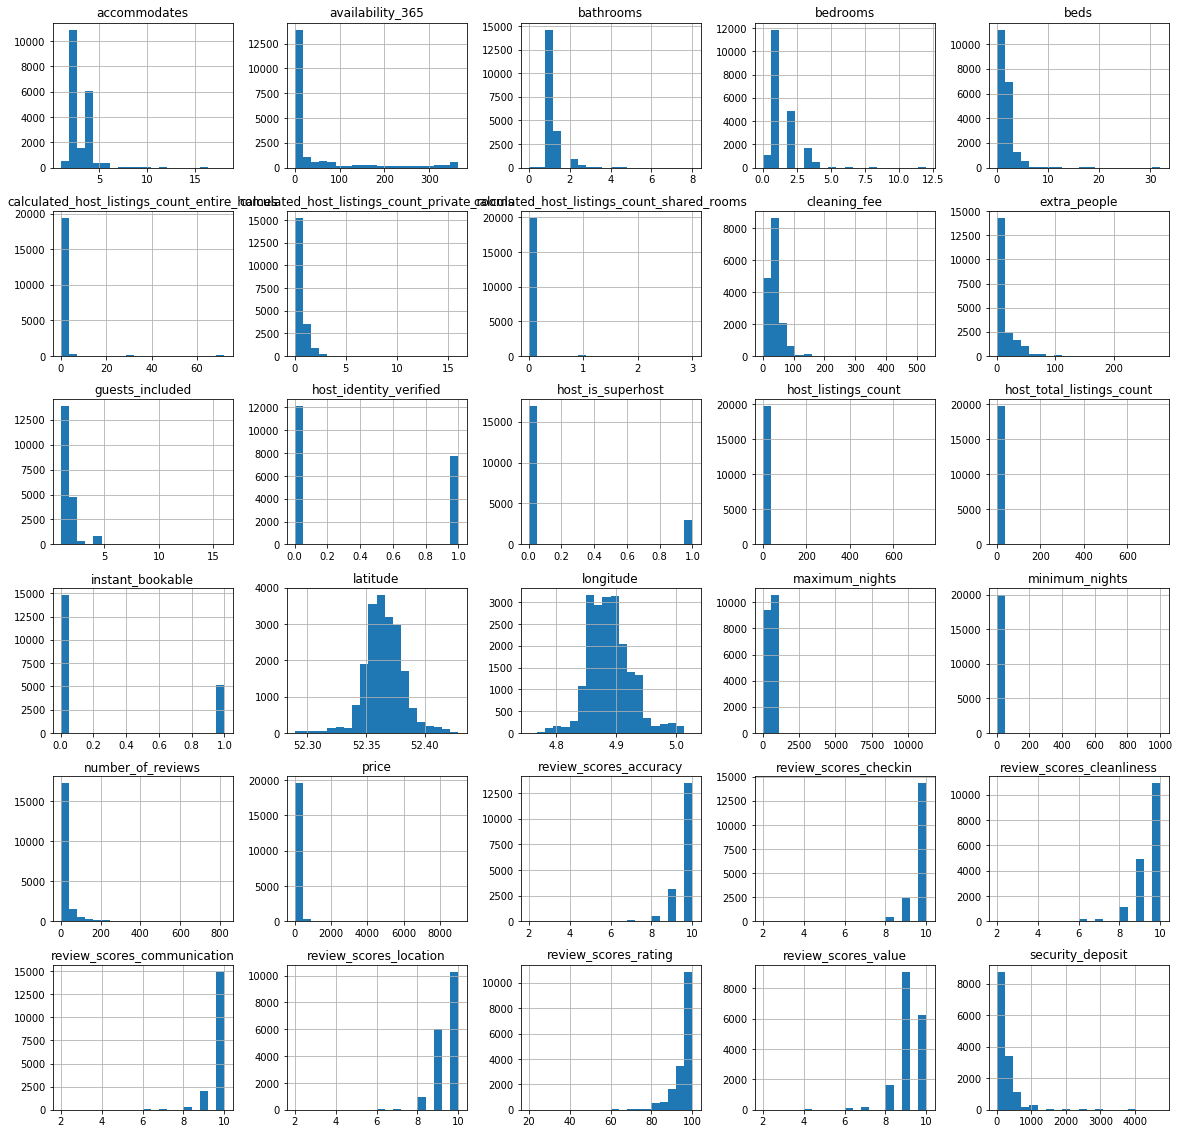

In [7]:
# Plotting the distribution of numerical and boolean categories (matplotlib)
df.hist(figsize=(20,20), bins=20);

# Other data cleaning steps

There is a column 'host since' containing the date a host was registered on Airbnb. For analyses with dates, it is sometimes easier to translate this date to 'number of days since registration'. Missing values are replaced with the median value here. 

In [8]:
# Host since to datetime
# datetime to 'host_days_active'
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 12, 8) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())
print("Min days as host:", df['host_days_active'].min())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1711.0
Median days as host: 1764.0
Min days as host: 2.0


The same procedure as above for the date of 'first review'. 

host_since host_response_time host_response_rate  host_is_superhost  \
0 2008-09-24     within an hour               100%                1.0   
1 2009-12-02     within an hour               100%                0.0   
2 2009-11-20     within an hour               100%                0.0   
3 2010-03-23     within an hour               100%                1.0   
4 2010-05-13     within an hour               100%                1.0   

   host_listings_count  host_total_listings_count  host_identity_verified  \
0                  1.0                        1.0                     0.0   
1                  2.0                        2.0                     0.0   
2                  2.0                        2.0                     0.0   
3                  1.0                        1.0                     1.0   
4                  3.0                        3.0                     1.0   

                            neighbourhood  latitude  longitude property_type  \
0  Oostelijk Havengebied - Indische Buurt  52.36575    4.94142     Apartment   
1                            Centrum-Oost  52.36509    4.89354     Townhouse   
2                            Centrum-West  52.37297    4.88339     Apartment   
3                            Centrum-West  52.38673    4.89208     Houseboat   
4                            Centrum-West  52.36719    4.89092     Apartment   

         room_type  accommodates  bathrooms  bedrooms  beds  bed_type  \
0     Private room             2        1.5       1.0   2.0  Real Bed   
1     Private room             2        1.0       1.0   1.0  Real Bed   
2  Entire home/apt             3        1.0       1.0   1.0  Real Bed   
3     Private room             2        1.0       1.0   1.0  Real Bed   
4     Private room             2        1.0       1.0   1.0  Real Bed   

                                           amenities  price  security_deposit  \
0  {Internet,Wifi,"Paid parking off premises","Bu...   59.0             200.0   
1  {TV,Internet,Wifi,"Paid parking off premises",...   80.0               NaN   
2  {TV,"Cable TV",Internet,Wifi,Kitchen,Elevator,...  125.0             300.0   
3  {TV,Internet,Wifi,Breakfast,Heating,"Smoke det...  155.0               0.0   
4  {Internet,Wifi,"Pets live on this property",Ca...   75.0               NaN   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0          60.0                1          20.0               3   
1           NaN                2           0.0               1   
2          40.0                2          10.0              14   
3           0.0                1           0.0               2   
4           NaN                1           0.0               2   

   maximum_nights  availability_365  number_of_reviews first_review  \
0              15                 0                277   2009-03-30   
1            1000               198                306   2010-03-02   
2              60                71                  3   2018-01-21   
3             730               251                206   2012-01-09   
4            1825               134                318   2010-08-22   

  last_review  review_scores_rating  review_scores_accuracy  \
0  2019-11-21                  98.0                    10.0   
1  2019-12-05                  89.0                    10.0   
2  2019-05-11                 100.0                    10.0   
3  2019-11-11                  99.0                    10.0   
4  2019-11-23                  98.0                    10.0   

   review_scores_cleanliness  review_scores_checkin  \
0                       10.0                   10.0   
1                       10.0                   10.0   
2                       10.0                   10.0   
3                       10.0                   10.0   
4                       10.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                     9.0                 10.0   
1

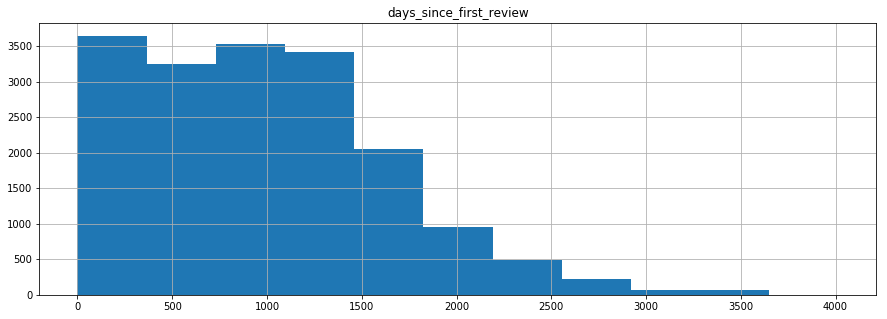

In [9]:
# Datum van first review to datetime,
# convert to number of days since first review 
df['first_review'] = pd.to_datetime(df['first_review']) 

# Calculating the number of days
df['days_since_first_review'] = (datetime(2019, 12, 8) - df['first_review']).astype('timedelta64[D]')


# Printing descriptives
df.hist(['days_since_first_review'], figsize=(15,5), bins=[0, 1*365, 2*365, 3*365, 4*365, 5*365, 6*365, 7*365, 8*365, 10*365, 11*365]), 9*365

#DOING Binning time since last review
# Thanks to https://pbpython.com/pandas-qcut-cut.html
#print(pd.qcut(df['days_since_first_review'], q=5).value_counts())
df['days_since_first_first_review'] = pd.qcut(df['days_since_first_review'],
                              q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])
df.head()




The same procedure as above for the date of 'last review'. 

count    17621.0
mean       359.0
std        406.0
min         29.0
25%         71.0
50%        155.0
75%        527.0
max       2720.0
Name: days_since_last_review, dtype: float64
(60.0, 113.0]      3585
(28.999, 60.0]     3541
(685.0, 2720.0]    3524
(234.0, 685.0]     3520
(113.0, 234.0]     3451
Name: days_since_last_review, dtype: int64


host_since host_response_time host_response_rate  host_is_superhost  \
0 2008-09-24     within an hour               100%                1.0   
1 2009-12-02     within an hour               100%                0.0   
2 2009-11-20     within an hour               100%                0.0   
3 2010-03-23     within an hour               100%                1.0   
4 2010-05-13     within an hour               100%                1.0   

   host_listings_count  host_total_listings_count  host_identity_verified  \
0                  1.0                        1.0                     0.0   
1                  2.0                        2.0                     0.0   
2                  2.0                        2.0                     0.0   
3                  1.0                        1.0                     1.0   
4                  3.0                        3.0                     1.0   

                            neighbourhood  latitude  longitude property_type  \
0  Oostelijk Havengebied - Indische Buurt  52.36575    4.94142     Apartment   
1                            Centrum-Oost  52.36509    4.89354     Townhouse   
2                            Centrum-West  52.37297    4.88339     Apartment   
3                            Centrum-West  52.38673    4.89208     Houseboat   
4                            Centrum-West  52.36719    4.89092     Apartment   

         room_type  accommodates  bathrooms  bedrooms  beds  bed_type  \
0     Private room             2        1.5       1.0   2.0  Real Bed   
1     Private room             2        1.0       1.0   1.0  Real Bed   
2  Entire home/apt             3        1.0       1.0   1.0  Real Bed   
3     Private room             2        1.0       1.0   1.0  Real Bed   
4     Private room             2        1.0       1.0   1.0  Real Bed   

                                           amenities  price  security_deposit  \
0  {Internet,Wifi,"Paid parking off premises","Bu...   59.0             200.0   
1  {TV,Internet,Wifi,"Paid parking off premises",...   80.0               NaN   
2  {TV,"Cable TV",Internet,Wifi,Kitchen,Elevator,...  125.0             300.0   
3  {TV,Internet,Wifi,Breakfast,Heating,"Smoke det...  155.0               0.0   
4  {Internet,Wifi,"Pets live on this property",Ca...   75.0               NaN   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0          60.0                1          20.0               3   
1           NaN                2           0.0               1   
2          40.0                2          10.0              14   
3           0.0                1           0.0               2   
4           NaN                1           0.0               2   

   maximum_nights  availability_365  number_of_reviews first_review  \
0              15                 0                277   2009-03-30   
1            1000               198                306   2010-03-02   
2              60                71                  3   2018-01-21   
3             730               251                206   2012-01-09   
4            1825               134                318   2010-08-22   

  last_review  review_scores_rating  review_scores_accuracy  \
0  2019-11-21                  98.0                    10.0   
1  2019-12-05                  89.0                    10.0   
2  2019-05-11                 100.0                    10.0   
3  2019-11-11                  99.0                    10.0   
4  2019-11-23                  98.0                    10.0   

   review_scores_cleanliness  review_scores_checkin  \
0                       10.0                   10.0   
1                       10.0                   10.0   
2                       10.0                   10.0   
3                       10.0                   10.0   
4                       10.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                     9.0                 10.0   
1

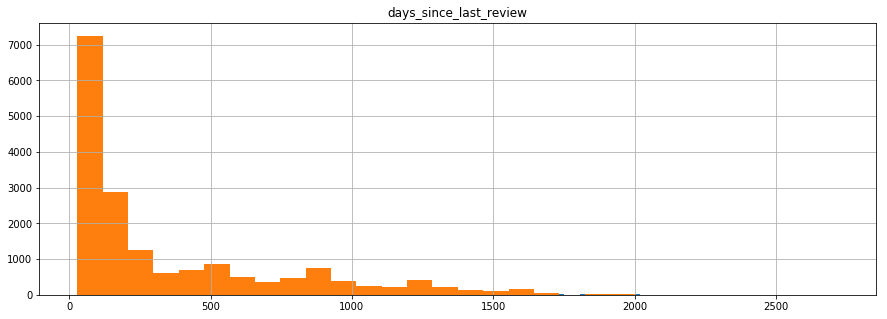

In [10]:
# Converting to datetime
df['last_review'] = pd.to_datetime(df['last_review']) 

# Calculating the number of days
df['days_since_last_review'] = (datetime(2020, 1, 6) - df['last_review']).astype('timedelta64[D]')

# Printing descriptives
print(df['days_since_last_review'].describe().round(decimals=0))
df.hist(['days_since_last_review'], bins=50)

# Distribution of the number of days since last review
df.days_since_last_review.hist(figsize=(15,5), bins=30);

#DOING Binning time since last review
# Thanks to https://pbpython.com/pandas-qcut-cut.html
print(pd.qcut(df['days_since_last_review'], q=5).value_counts())

df['days_since_last_review_bin'] = pd.qcut(df['days_since_last_review'],
                              q=5,
                              labels=['Extremely active', 'Very active', 'Active', 'Inactive', 'Slumbering'])
df.head()
#TODO Remove slumbering accounts?

There are many missing values in the column 'Host response time' (how quickly a host responds to a message): 47% has no value, which is too much to omit from the dataset. Therefore we introduce the category 'unknown'. 

In [11]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

Null values: 9349
Proportion: 46.7%


unknown               0.466866
within an hour        0.265268
within a few hours    0.129238
within a day          0.119900
a few days or more    0.018727
Name: host_response_time, dtype: float64

The same for 'host_response_rate', but first we need to place the numerical values into bins. 

In [12]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

Mean host response rate: 93.0
Median host response rate: 100.0
Proportion of 100% host response rates: 78.2%


unknown    9349
100%       8351
50-89%     1462
0-49%       549
90-99%      314
Name: host_response_rate, dtype: int64

There are a couple of accomodations with missing values for 'last review', we can omit these. 

In [13]:
df.dropna(subset=['host_since'], inplace=True)
df.isna().sum()

host_since                                         0
host_response_time                                 0
host_response_rate                                 0
host_is_superhost                                  0
host_listings_count                                0
host_total_listings_count                          0
host_identity_verified                             0
neighbourhood                                      0
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                          6
bedrooms                                          13
beds                                              31
bed_type                                           0
amenities                                          0
price                                         

Now we can make a histogram of Airbnb-activity (days since last review). 

C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


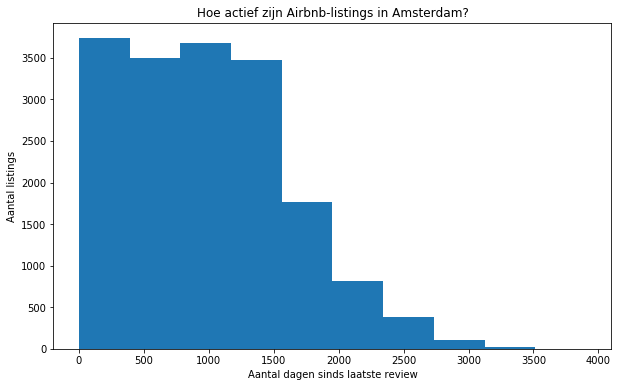

In [14]:
num_bins = 10

fig, ax = plt.subplots(figsize=(10, 6))
#ax  = plt.subplots(figsize=(20, 10))

# the histogram of the data
n, bins, patches = ax.hist(df['days_since_first_review'], num_bins)
ax.set_ylabel('Aantal listings')
ax.set_xlabel('Aantal dagen sinds laatste review')
ax.set_title('Hoe actief zijn Airbnb-listings in Amsterdam?')
plt.show()

In [15]:
df.head(25)

host_since  host_response_time host_response_rate  host_is_superhost  \
0  2008-09-24      within an hour               100%                1.0   
1  2009-12-02      within an hour               100%                0.0   
2  2009-11-20      within an hour               100%                0.0   
3  2010-03-23      within an hour               100%                1.0   
4  2010-05-13      within an hour               100%                1.0   
5  2010-05-13      within an hour               100%                1.0   
6  2010-05-27             unknown            unknown                0.0   
7  2010-07-23      within an hour               100%                1.0   
9  2010-08-01        within a day             50-89%                0.0   
10 2009-12-22  within a few hours               100%                0.0   
11 2010-08-20             unknown            unknown                0.0   
12 2010-08-24  within a few hours               100%                0.0   
13 2010-08-31      within an hour               100%                1.0   
14 2010-09-06  within a few hours               100%                1.0   
15 2010-09-12        within a day             50-89%                0.0   
16 2010-09-12      within an hour               100%                1.0   
17 2010-09-12      within an hour               100%                1.0   
18 2010-09-12             unknown            unknown                0.0   
19 2010-07-30      within an hour               100%                1.0   
20 2010-09-27      within an hour               100%                1.0   
21 2010-09-28      within an hour               100%                0.0   
22 2010-09-27      within an hour               100%                1.0   
23 2010-10-13      within an hour               100%                0.0   
24 2010-10-15             unknown            unknown                0.0   
25 2010-10-16             unknown            unknown                0.0   

    host_listings_count  host_total_listings_count  host_identity_verified  \
0                   1.0                        1.0                     0.0   
1                   2.0                        2.0                     0.0   
2                   2.0                        2.0                     0.0   
3                   1.0                        1.0                     1.0   
4                   3.0                        3.0                     1.0   
5                   3.0                        3.0                     1.0   
6                   1.0                        1.0                     1.0   
7                   1.0                        1.0                     1.0   
9                   1.0                        1.0                     1.0   
10                  1.0                        1.0                     0.0   
11                  1.0                        1.0                     1.0   
12                  1.0                        1.0                     1.0   
13                  2.0                        2.0                     0.0   
14                  1.0                        1.0                     1.0   
15                  1.0                        1.0                     1.0   
16                  1.0                        1.0                     0.0   
17                  1.0                        1.0                     0.0   
18                  3.0                        3.0                     1.0   
19                  1.0                        1.0                     0.0   
20                  5.0                        5.0                     0.0   
21                  1.0                        1.0                     1.0   
22                  5.0                        5.0                     0.0   
23                  1.0                        1.0                     1.0   
24                  1.0                        1.0                     0.0   
25                  1.0                        1.0                     0.0   

                       

Missing values for bedrooms, beds, and bathrooms are replaced with the median. 

In [16]:
df.bed_type.value_counts()
df.drop('bed_type', axis=1, inplace=True)
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

If a _fee_ (security, cleaning, or extra people) is missing, we assume this value needs to be zero. 

In [17]:
# Security deposit set missing to zero
df.security_deposit.isna().sum()
df.security_deposit.fillna(0, inplace=True)

# Cleaning fee set missing to zero
df.cleaning_fee.isna().sum()
df.cleaning_fee.fillna(0, inplace=True)

# Extra people fee set missing to zero
df.extra_people.isna().sum()
df.extra_people.fillna(0, inplace=True)

There are many _property types_, that should be summarized into fewer categories. 

In [18]:
df.property_type.value_counts()

Apartment                 15116
House                      1653
Townhouse                   673
Bed and breakfast           413
Loft                        376
Condominium                 357
Boat                        333
Houseboat                   322
Guest suite                 157
Aparthotel                  111
Serviced apartment           67
Guesthouse                   48
Boutique hotel               42
Villa                        38
Hotel                        36
Hostel                       32
Other                        31
Tiny house                   14
Cabin                        13
Cottage                      12
Farm stay                     5
Bungalow                      4
Chalet                        2
Barn                          2
Yurt                          2
Earth house                   1
Dome house                    1
Island                        1
Campsite                      1
Camper/RV                     1
Casa particular (Cuba)        1
Lighthou

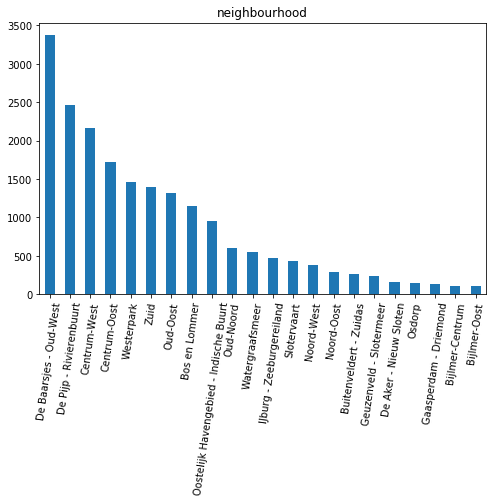

De Baarsjes - Oud-West                    0.169628
De Pijp - Rivierenbuurt                   0.123773
Centrum-West                              0.108723
Centrum-Oost                              0.086727
Westerpark                                0.073388
Zuid                                      0.070368
Oud-Oost                                  0.066190
Bos en Lommer                             0.057784
Oostelijk Havengebied - Indische Buurt    0.048321
Oud-Noord                                 0.030453
Watergraafsmeer                           0.027432
IJburg - Zeeburgereiland                  0.023859
Slotervaart                               0.021795
Noord-West                                0.019127
Noord-Oost                                0.014597
Buitenveldert - Zuidas                    0.013037
Geuzenveld - Slotermeer                   0.012030
De Aker - Nieuw Sloten                    0.007953
Osdorp                                    0.007248
Gaasperdam - Driemond          

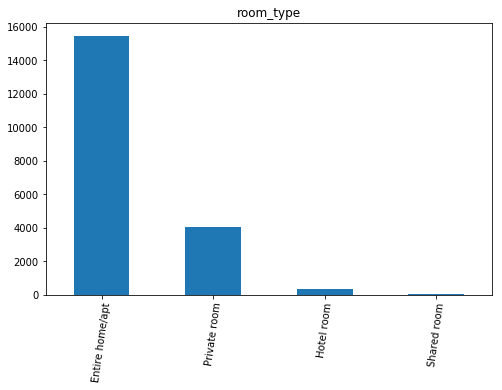

Entire home/apt    0.777923
Private room       0.203000
Hotel room         0.016258
Shared room        0.002819
Name: room_type, dtype: float64


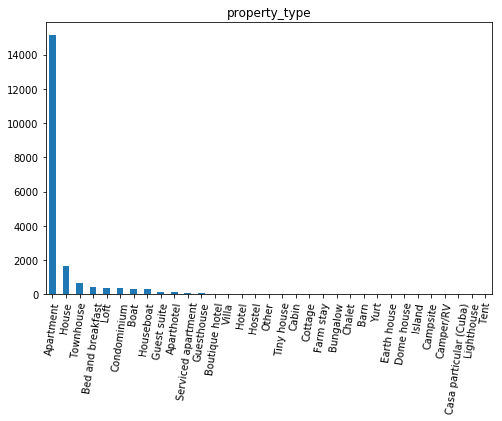

Apartment                 0.760860
House                     0.083203
Townhouse                 0.033875
Bed and breakfast         0.020788
Loft                      0.018926
Condominium               0.017969
Boat                      0.016761
Houseboat                 0.016208
Guest suite               0.007903
Aparthotel                0.005587
Serviced apartment        0.003372
Guesthouse                0.002416
Boutique hotel            0.002114
Villa                     0.001913
Hotel                     0.001812
Hostel                    0.001611
Other                     0.001560
Tiny house                0.000705
Cabin                     0.000654
Cottage                   0.000604
Farm stay                 0.000252
Bungalow                  0.000201
Chalet                    0.000101
Barn                      0.000101
Yurt                      0.000101
Earth house               0.000050
Dome house                0.000050
Island                    0.000050
Campsite            

In [19]:
for col in ['neighbourhood', 'room_type', 'property_type']:
    category_count_plot(col, figsize=(8,5))
    print(df[col].value_counts(normalize=True))

In [20]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Bed and Breakfast': 'Hotel',
    'Loft': 'Apartment',
    'Condominium': 'Apartment',
    'Houseboat': 'Boat',
    'Guest suite': 'Apartment',
    'Aparthotel': 'Hotel',
    'Serviced apartment': 'Apartment',
    'Guesthouse': 'House',    
    'Boutique hotel': 'Hotel',
    'Villa': 'House',
    'Hostel': 'Hotel',
    'Tiny house': 'House',
    'Cabin': 'House',
    'Cottage': 'House',
    'Bungalow': 'House',
    'Chalet': 'House',
    'Earth house': 'House'
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment','Hotel','Boat']), 'property_type'] = 'Other'

De Baarsjes - Oud-West                    3370
De Pijp - Rivierenbuurt                   2459
Centrum-West                              2160
Centrum-Oost                              1723
Westerpark                                1458
Zuid                                      1398
Oud-Oost                                  1315
Bos en Lommer                             1148
Oostelijk Havengebied - Indische Buurt     960
Oud-Noord                                  605
Watergraafsmeer                            545
IJburg - Zeeburgereiland                   474
Slotervaart                                433
Noord-West                                 380
Noord-Oost                                 290
Buitenveldert - Zuidas                     259
Geuzenveld - Slotermeer                    239
De Aker - Nieuw Sloten                     158
Osdorp                                     144
Gaasperdam - Driemond                      130
Bijlmer-Centrum                            113
Bijlmer-Oost 

Entire home/apt    15455
Private room        4033
Hotel room           323
Shared room           56
Name: room_type, dtype: int64


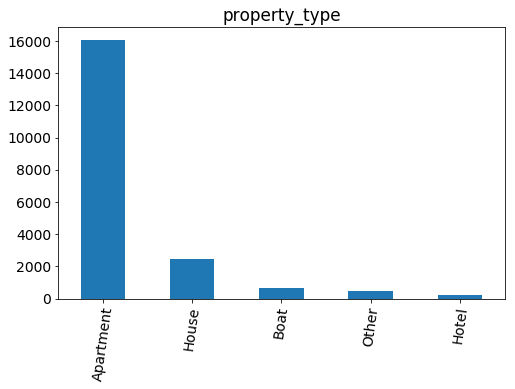

Apartment    16073
House         2458
Boat           655
Other          460
Hotel          221
Name: property_type, dtype: int64


In [21]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
for col in ['neighbourhood', 'room_type', 'property_type']:
    category_count_plot(col, figsize=(8,5))
    print(df[col].value_counts(normalize=False))

The amenities are in an embedded list. A long list of  amenities for each listing is difficult to work with. We first get a list of all possible amenities, and add these as separate column. If a listing offers an amenity, it will have a value '1' for this amenity, and a value '0' is the amenity is not present at this listing (this process is called one-hot encoding). 

In [22]:
#df.amenities[:1].replace({'{':''}).replace({'}':''}).replace({'"':''}).replace({'(':''}).replace({')':''}).replace({'/':''}).replace({'-':' '}).replace({'_':' '}).replace({':':' '}).replace({'’':''}).replace({'.':' '}).replace({'  ':' '})


In [23]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',') if x.strip()]
amenities_set = set(amenities_set)
amenities_set

{'24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bread maker',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower',
 'Fixed grab bars for toilet',
 'Fl

In [24]:
#df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
len(df[df['amenities'].str.contains("Cat(s)", regex=False)])
unique_amenities = list(amenities_set)

In [25]:
# Create encoding for every amenity
for i in range(len(unique_amenities)):
    df.loc[df['amenities'].str.contains(unique_amenities[i], regex=False), unique_amenities[i]] = 1
    
df.head(30)

host_since  host_response_time host_response_rate  host_is_superhost  \
0  2008-09-24      within an hour               100%                1.0   
1  2009-12-02      within an hour               100%                0.0   
2  2009-11-20      within an hour               100%                0.0   
3  2010-03-23      within an hour               100%                1.0   
4  2010-05-13      within an hour               100%                1.0   
5  2010-05-13      within an hour               100%                1.0   
6  2010-05-27             unknown            unknown                0.0   
7  2010-07-23      within an hour               100%                1.0   
9  2010-08-01        within a day             50-89%                0.0   
10 2009-12-22  within a few hours               100%                0.0   
11 2010-08-20             unknown            unknown                0.0   
12 2010-08-24  within a few hours               100%                0.0   
13 2010-08-31      within an hour               100%                1.0   
14 2010-09-06  within a few hours               100%                1.0   
15 2010-09-12        within a day             50-89%                0.0   
16 2010-09-12      within an hour               100%                1.0   
17 2010-09-12      within an hour               100%                1.0   
18 2010-09-12             unknown            unknown                0.0   
19 2010-07-30      within an hour               100%                1.0   
20 2010-09-27      within an hour               100%                1.0   
21 2010-09-28      within an hour               100%                0.0   
22 2010-09-27      within an hour               100%                1.0   
23 2010-10-13      within an hour               100%                0.0   
24 2010-10-15             unknown            unknown                0.0   
25 2010-10-16             unknown            unknown                0.0   
26 2010-10-17        within a day               100%                0.0   
27 2010-10-17        within a day               100%                0.0   
28 2010-10-25        within a day               100%                0.0   
29 2010-11-04      within an hour               100%                1.0   
30 2010-11-27        within a day               100%                0.0   

    host_listings_count  host_total_listings_count  host_identity_verified  \
0                   1.0                        1.0                     0.0   
1                   2.0                        2.0                     0.0   
2                   2.0                        2.0                     0.0   
3                   1.0                        1.0                     1.0   
4                   3.0                        3.0                     1.0   
5                   3.0                        3.0                     1.0   
6                   1.0                        1.0                     1.0   
7                   1.0                        1.0                     1.0   
9                   1.0                        1.0                     1.0   
10                  1.0                        1.0                     0.0   
11                  1.0                        1.0                     1.0   
12                  1.0                        1.0                     1.0   
13                  2.0                        2.0                     0.0   
14                  1.0                        1.0                     1.0   
15                  1.0                        1.0                     1.0   
16                  1.0                        1.0                     0.0   
17                  1.0                        1.0                     0.0   
18                  3.0                        3.0                     1.0   
19                  1.0                        1.0                     0.0   
20                  5.0                        5.0                     0.0   
21                  1.0                

In [26]:
# Check
print(len(df[df['amenities'].str.contains("charger")])) # 294
print(df['EV charger'].sum(axis=0, skipna=True)) # 294

print(len(df[df['amenities'].str.contains("Cat")])) # 657
print(df['Cat(s)'].sum(axis=0, skipna=True)) # 657

294
294.0
657
657.0


In [27]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,45:].columns
cols_to_replace_nulls
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

## Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

Before we visualize data, the current dataset is saved. This is the data used in the accompanying Power BI Dashboard (https://klaasjan.eu/airbnb/).

In [28]:
# Save clean data to csv
print(f"The dataset contains {len(df)} Airbnb listings")
df.to_csv(r'airbnb_clean.csv', index=False)

The dataset contains 19867 Airbnb listings


# Exploration / visualiation (no changes to data beyond this point)

Visualizing review scores

In [29]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [30]:
# GEO
# Importing the Amsterdam neighbourhood  GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('http://klaasjan.eu/files/airbnb/neighbourhoods.geojson')
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)
map_df.head(20)

neighbourhood  \
0                             Bijlmer-Oost   
1                               Noord-Oost   
2                               Noord-West   
3                                Oud-Noord   
4                 IJburg - Zeeburgereiland   
5                             Centrum-West   
6   Oostelijk Havengebied - Indische Buurt   
7                             Centrum-Oost   
8                                 Oud-Oost   
9                          Watergraafsmeer   
10                   Gaasperdam - Driemond   
11                              Westerpark   
12                         Bijlmer-Centrum   
13                 De Pijp - Rivierenbuurt   
14                                    Zuid   
15                  Buitenveldert - Zuidas   
16                  De Baarsjes - Oud-West   
17                           Bos en Lommer   
18                 Geuzenveld - Slotermeer   
19                             Slotervaart   

                                             geometry  
0   MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4...  
1   MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5...  
2   MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4...  
3   MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4...  
4   MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5...  
5   MULTIPOLYGON Z (((4.90640 52.38004 42.97078, 4...  
6   MULTIPOLYGON Z (((4.96131 52.35913 43.00823, 4...  
7   MULTIPOLYGON Z (((4.93297 52.37041 42.98810, 4...  
8   MULTIPOLYGON Z (((4.93743 52.35774 43.01043, 4...  
9   MULTIPOLYGON Z (((4.96971 52.35636 43.01317, 4...  
10  MULTIPOLYGON Z (((5.02154 52.30246 43.10781, 5...  
11  MULTIPOLYGON Z (((4.89508 52.38869 42.95535, 4...  
12  MULTIPOLYGON Z (((4.97184 52.28436 43.13905, 4...  
13  MULTIPOLYGON Z (((4.91498 52.34215 43.03750, 4...  
14  MULTIPOLYGON Z (((4.88738 52.36023 43.00532, 4...  
15  MULTIPOLYGON Z (((4.89907 52.33044 43.05777, 4...  
16  MULTIPOLYGON Z (((4.88209 52.36205 43.00203, 4...  
17  MULTIPOLYGON Z (((4.86496 52.38896 42.95433, 4...  
18  MULTIPOLYGON Z (((4.83945 52.38404 42.96248, 4...  
19  MULTIPOLYGON Z (((4.85049 52.36424 42.99757, 4...

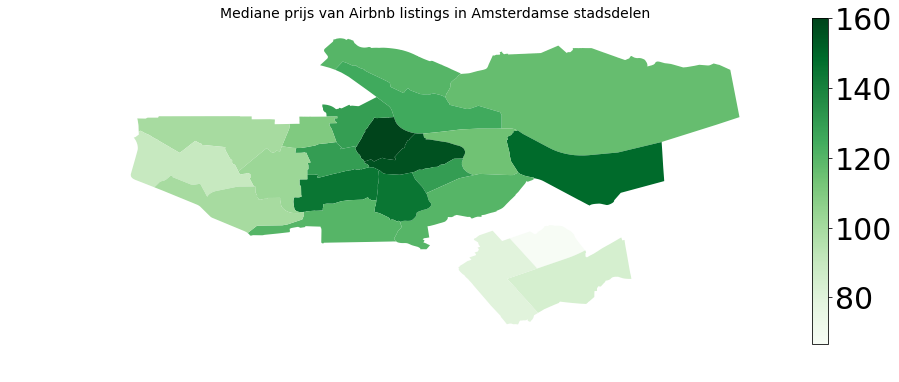

                                        number_of_listings  median_price
neighbourhood                                                           
Bijlmer-Centrum                                        113          80.0
Bijlmer-Oost                                           106          66.5
Bos en Lommer                                         1148         110.0
Buitenveldert - Zuidas                                 259         120.0
Centrum-Oost                                          1723         156.0
Centrum-West                                          2160         160.0
De Aker - Nieuw Sloten                                 158         100.0
De Baarsjes - Oud-West                                3370         130.0
De Pijp - Rivierenbuurt                               2459         145.0
Gaasperdam - Driemond                                  130          84.5
Geuzenveld - Slotermeer                                239         100.0
IJburg - Zeeburgereiland                           

In [31]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = 280, 280


# Creating a dataframe of listing counts and median price by borough
neighbourhood_df = pd.DataFrame(df.groupby('neighbourhood').size())
neighbourhood_df.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_df['median_price'] = df.groupby('neighbourhood').price.median().values

# Joining the dataframes
neighbourhood_map_df = map_df.set_index('neighbourhood').join(neighbourhood_df)
                  
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='number_of_listings', cmap='Greens', ax=ax1, rasterized=True,)


ax1.axis('off')
ax1.set_title('Aantal Airbnb listings in Amsterdamse stadsdelen', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='median_price', cmap='Greens', ax=ax2)
ax2.axis('off')
ax2.set_title('Mediane prijs van Airbnb listings in Amsterdamse stadsdelen', fontsize=14)#
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=min(neighbourhood_map_df.median_price), vmax=max(neighbourhood_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()
print(neighbourhood_df)

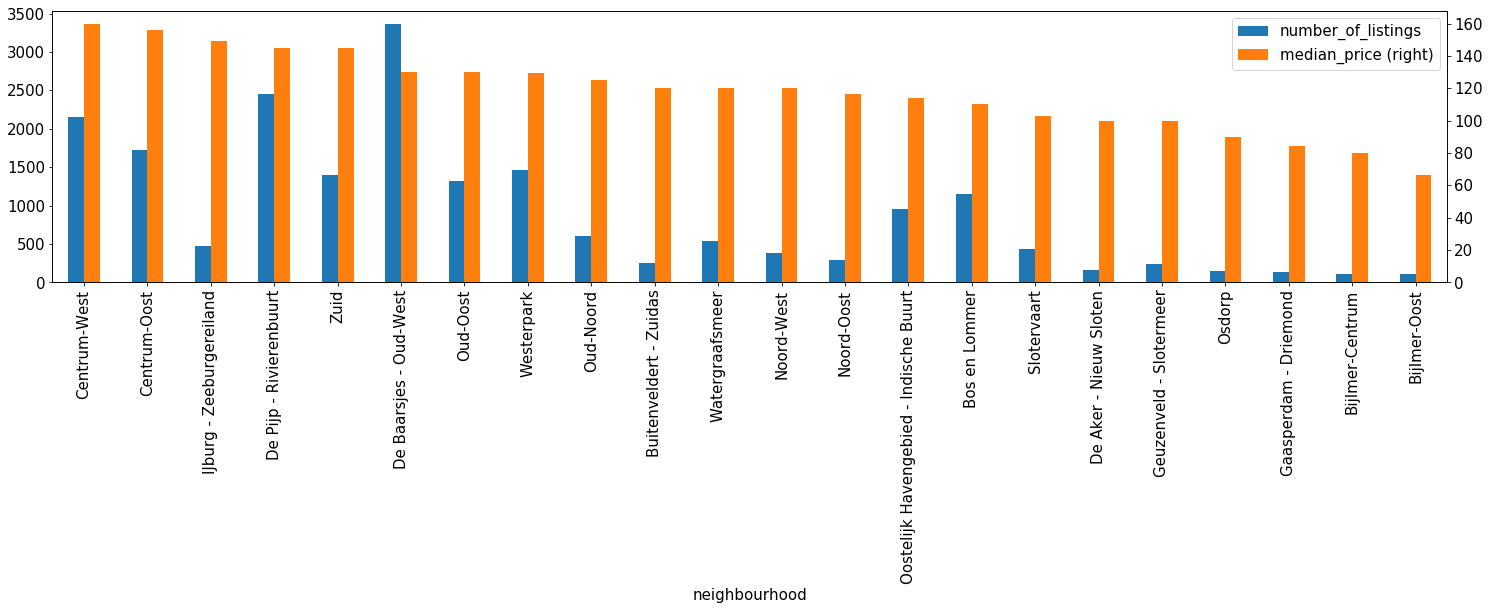

In [32]:
# Plot number of listings and median price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
neighbourhood_df_sorted = neighbourhood_df.sort_values('median_price', ascending=False)
neighbourhood_df_sorted.plot( kind= 'bar' , secondary_y= 'median_price' , rot= 90 )
plt.xticks(rotation='vertical')

plt.show()

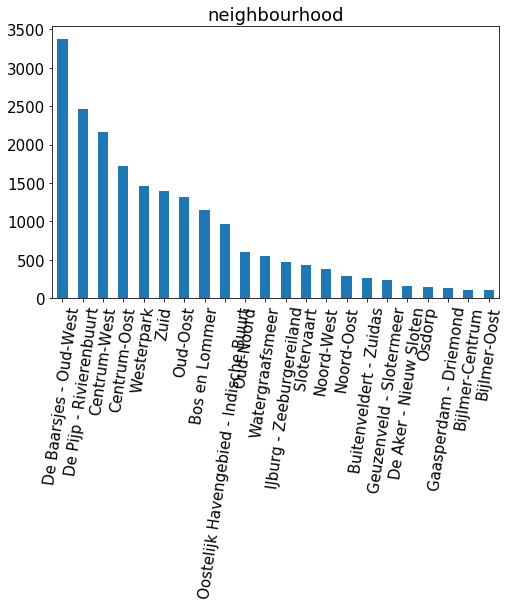

De Baarsjes - Oud-West                    0.169628
De Pijp - Rivierenbuurt                   0.123773
Centrum-West                              0.108723
Centrum-Oost                              0.086727
Westerpark                                0.073388
Zuid                                      0.070368
Oud-Oost                                  0.066190
Bos en Lommer                             0.057784
Oostelijk Havengebied - Indische Buurt    0.048321
Oud-Noord                                 0.030453
Watergraafsmeer                           0.027432
IJburg - Zeeburgereiland                  0.023859
Slotervaart                               0.021795
Noord-West                                0.019127
Noord-Oost                                0.014597
Buitenveldert - Zuidas                    0.013037
Geuzenveld - Slotermeer                   0.012030
De Aker - Nieuw Sloten                    0.007953
Osdorp                                    0.007248
Gaasperdam - Driemond          

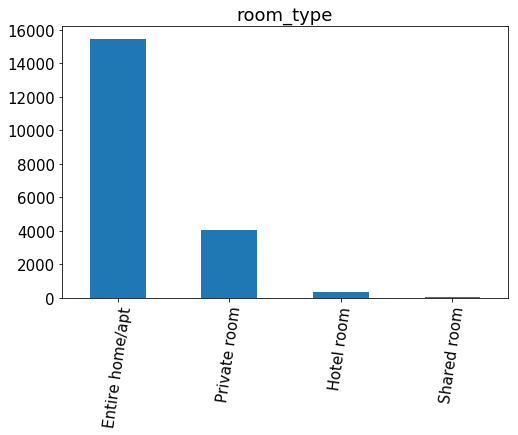

Entire home/apt    0.777923
Private room       0.203000
Hotel room         0.016258
Shared room        0.002819
Name: room_type, dtype: float64


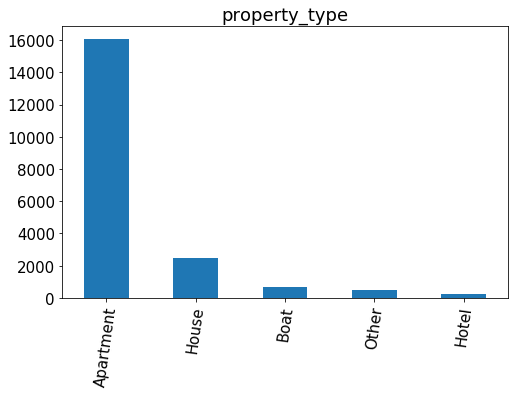

Apartment    0.809030
House        0.123723
Boat         0.032969
Other        0.023154
Hotel        0.011124
Name: property_type, dtype: float64


In [33]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 250, 50
for col in ['neighbourhood', 'room_type', 'property_type']:
    category_count_plot(col, figsize=(8,5))
    print(df[col].value_counts(normalize=True))

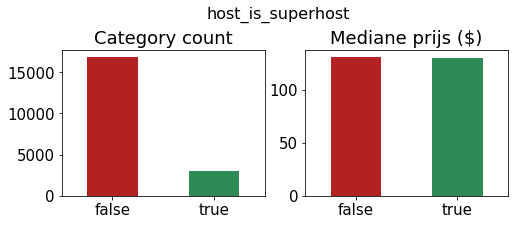


P-value is 2.00e-01
There are 16853 without host_is_superhost, with a median price of 131.0
There are 3014 with host_is_superhost, with a median price of 130.0
0.0    0.848291
1.0    0.151709
Name: host_is_superhost, dtype: float64



P-value is 9.65e-02
There are 12094 without host_identity_verified, with a median price of 135.0
There are 7773 with host_identity_verified, with a median price of 130.0


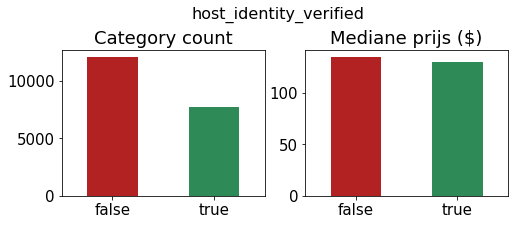


P-value is 9.65e-02
There are 12094 without host_identity_verified, with a median price of 135.0
There are 7773 with host_identity_verified, with a median price of 130.0


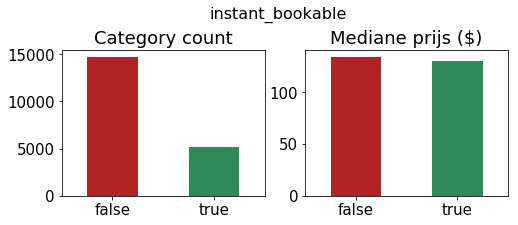


P-value is 1.95e-06
There are 14716 without instant_bookable, with a median price of 134.0
There are 5151 with instant_bookable, with a median price of 130.0
Effect is significant!
0    0.740726
1    0.259274
Name: instant_bookable, dtype: float64


In [34]:
superhost = binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

test2 = binary_count_and_price_plot('host_identity_verified')
binary_count_and_price_plot('host_identity_verified')

test3 = binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))



There are 7727 without Hot water, with a mean rating of 94.27332729390449
There are 9529 with Hot water, with a mean rating of 95.99916045755063
P-value is 3.58e-08
Effect is significant! Here's a plot:


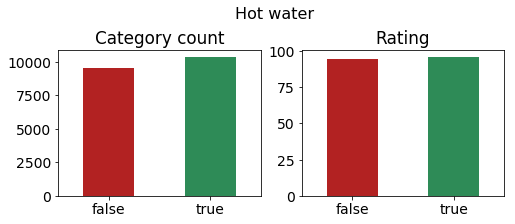


There are 12443 without Microwave, with a mean rating of 94.94583299847304
There are 4813 with Microwave, with a mean rating of 95.95158944525244
P-value is 5.42e-12
Effect is significant! Here's a plot:


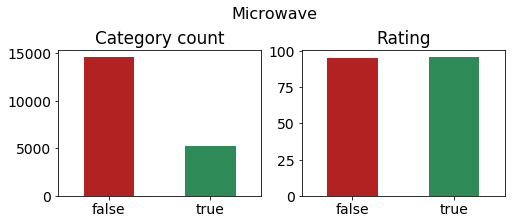


There are 339 without Wifi, with a mean rating of 91.41297935103245
There are 16917 with Wifi, with a mean rating of 95.30277235916533
P-value is 1.89e-01

There are 15370 without Long term stays allowed, with a mean rating of 95.2402081977879
There are 1886 with Long term stays allowed, with a mean rating of 95.1134676564157
P-value is 6.19e-20
Effect is significant! Here's a plot:


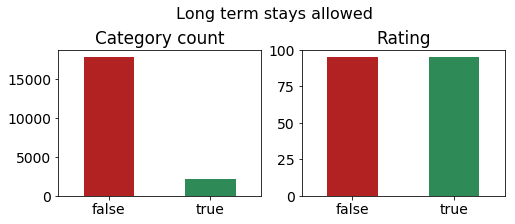


There are 5592 without Hair dryer, with a mean rating of 94.16738197424893
There are 11664 with Hair dryer, with a mean rating of 95.73405349794238
P-value is 8.35e-12
Effect is significant! Here's a plot:


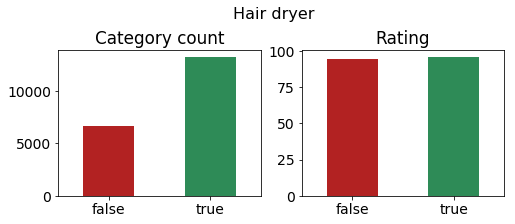


There are 15688 without Bathtub, with a mean rating of 95.08828403875573
There are 1568 with Bathtub, with a mean rating of 96.6077806122449
P-value is 7.38e-37
Effect is significant! Here's a plot:


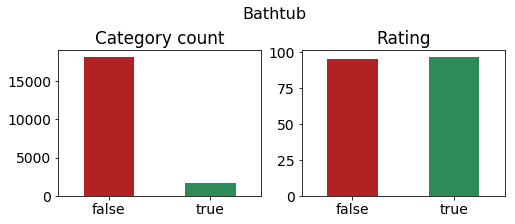


There are 16981 without EV charger, with a mean rating of 95.20552382074082
There are 275 with EV charger, with a mean rating of 96.51272727272728
P-value is 3.35e-01

There are 16237 without Waterfront, with a mean rating of 95.15649442631027
There are 1019 with Waterfront, with a mean rating of 96.33954857703631
P-value is 4.00e-16
Effect is significant! Here's a plot:


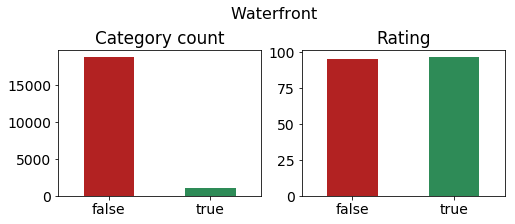


There are 9672 without Dryer, with a mean rating of 94.76023573200993
There are 7584 with Dryer, with a mean rating of 95.82080696202532
P-value is 1.21e-37
Effect is significant! Here's a plot:


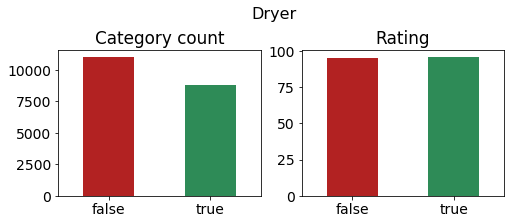


There are 4269 without Washer, with a mean rating of 94.20543452799251
There are 12987 with Washer, with a mean rating of 95.56194656194656
P-value is 4.73e-02

There are 14638 without Lock on bedroom door, with a mean rating of 95.25495286241289
There are 2618 with Lock on bedroom door, with a mean rating of 95.0664629488159
P-value is 9.08e-01

There are 5353 without Shampoo, with a mean rating of 94.58135624883244
There are 11903 with Shampoo, with a mean rating of 95.51642443081576
P-value is 4.94e-01

There are 15652 without Free parking on premises, with a mean rating of 95.23741374904165
There are 1604 with Free parking on premises, with a mean rating of 95.11845386533666
P-value is 9.15e-01

There are 12704 without Paid parking off premises, with a mean rating of 94.82312657430731
There are 4552 with Paid parking off premises, with a mean rating of 96.35171353251319
P-value is 1.32e-04
Effect is significant! Here's a plot:


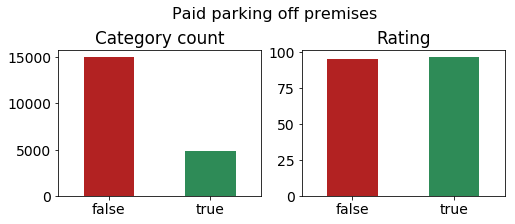


There are 17249 without Ground floor access, with a mean rating of 95.22685373065106
There are 7 with Ground floor access, with a mean rating of 94.0
P-value is 8.74e-01

There are 15250 without Safety card, with a mean rating of 95.19311475409836
There are 2006 with Safety card, with a mean rating of 95.4790628115653
P-value is 1.04e-10
Effect is significant! Here's a plot:


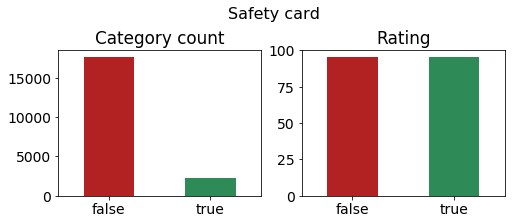


There are 14939 without Buzzer/wireless intercom, with a mean rating of 95.18441662761899
There are 2317 with Buzzer/wireless intercom, with a mean rating of 95.49676305567544
P-value is 5.76e-02

There are 16416 without Room-darkening shades, with a mean rating of 95.1652655945419
There are 840 with Room-darkening shades, with a mean rating of 96.42023809523809
P-value is 5.13e-11
Effect is significant! Here's a plot:


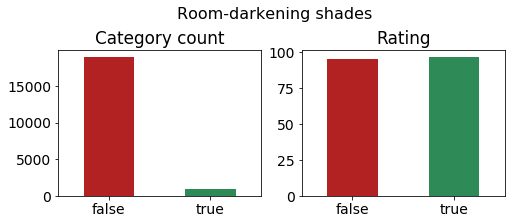


There are 11290 without Internet, with a mean rating of 95.29645704162976
There are 5966 with Internet, with a mean rating of 95.0936976198458
P-value is 4.41e-02

There are 15549 without Children’s books and toys, with a mean rating of 95.04289664930221
There are 1707 with Children’s books and toys, with a mean rating of 96.89748096074986
P-value is 1.97e-18
Effect is significant! Here's a plot:


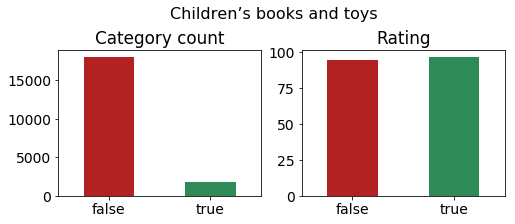


There are 17115 without Disabled parking spot, with a mean rating of 95.21747005550687
There are 141 with Disabled parking spot, with a mean rating of 96.30496453900709
P-value is 2.76e-01

There are 17213 without Beachfront, with a mean rating of 95.22378434903851
There are 43 with Beachfront, with a mean rating of 96.25581395348837
P-value is 9.69e-01

There are 17233 without Firm mattress, with a mean rating of 95.22410491498869
There are 23 with Firm mattress, with a mean rating of 96.91304347826087
P-value is 2.86e-01

There are 13183 without Patio or balcony, with a mean rating of 94.88454828187818
There are 4073 with Patio or balcony, with a mean rating of 96.3326786152713
P-value is 1.62e-03

There are 16866 without Wide doorway to guest bathroom, with a mean rating of 95.18599549389305
There are 390 with Wide doorway to guest bathroom, with a mean rating of 96.97179487179487
P-value is 3.05e-02

There are 15549 without Garden or backyard, with a mean rating of 95.084957231976

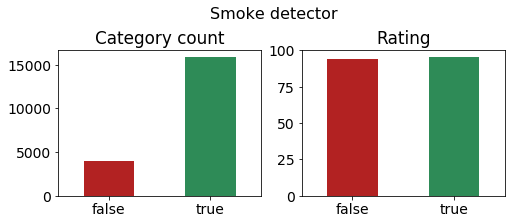


There are 15996 without Self check-in, with a mean rating of 95.16685421355339
There are 1260 with Self check-in, with a mean rating of 95.98174603174603
P-value is 6.65e-02

There are 16455 without Free street parking, with a mean rating of 95.21446368884837
There are 801 with Free street parking, with a mean rating of 95.47066167290886
P-value is 1.23e-01

There are 10582 without Family/kid friendly, with a mean rating of 95.21139671139672
There are 6674 with Family/kid friendly, with a mean rating of 95.25007491759065
P-value is 4.96e-15
Effect is significant! Here's a plot:


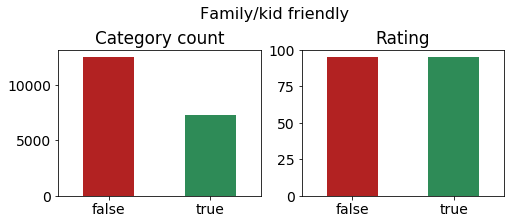


There are 17198 without Pool, with a mean rating of 95.22630538434701
There are 58 with Pool, with a mean rating of 95.24137931034483
P-value is 9.43e-08
Effect is significant! Here's a plot:


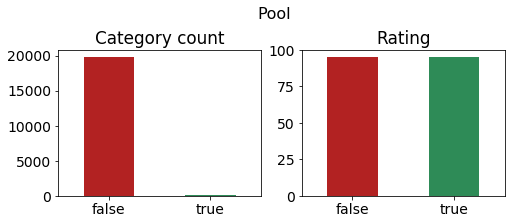


There are 1797 without Kitchen, with a mean rating of 94.21981079577073
There are 15459 with Kitchen, with a mean rating of 95.34335985510059
P-value is 1.86e-07
Effect is significant! Here's a plot:


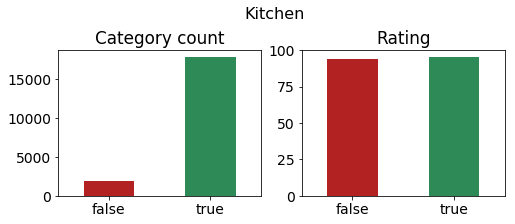


There are 10588 without First aid kit, with a mean rating of 94.89676992822062
There are 6668 with First aid kit, with a mean rating of 95.749700059988
P-value is 3.33e-11
Effect is significant! Here's a plot:


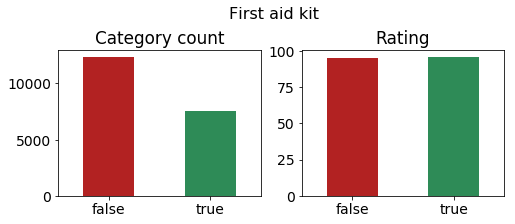


There are 16976 without Lake access, with a mean rating of 95.20581998114986
There are 280 with Lake access, with a mean rating of 96.47142857142858
P-value is 2.26e-02

There are 10672 without Coffee maker, with a mean rating of 94.65732758620689
There are 6584 with Coffee maker, with a mean rating of 96.14869380315918
P-value is 2.24e-09
Effect is significant! Here's a plot:


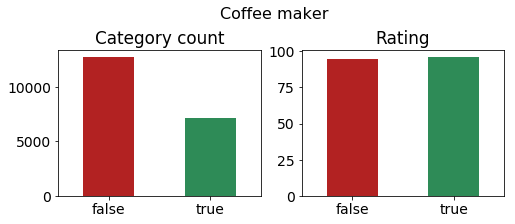


There are 17254 without Air purifier, with a mean rating of 95.22644024574012
There are 2 with Air purifier, with a mean rating of 94.5
P-value is 8.52e-01

There are 17254 without Mobile hoist, with a mean rating of 95.22644024574012
There are 2 with Mobile hoist, with a mean rating of 94.5
P-value is 9.33e-01

There are 16239 without Breakfast, with a mean rating of 95.1807377301558
There are 1017 with Breakfast, with a mean rating of 95.95476892822026
P-value is 1.67e-01

There are 17248 without Shower gel, with a mean rating of 95.2254754174397
There are 8 with Shower gel, with a mean rating of 97.125
P-value is 3.07e-01

There are 10025 without Dishes and silverware, with a mean rating of 94.59620947630923
There are 7231 with Dishes and silverware, with a mean rating of 96.09998617065413
P-value is 1.91e-05
Effect is significant! Here's a plot:


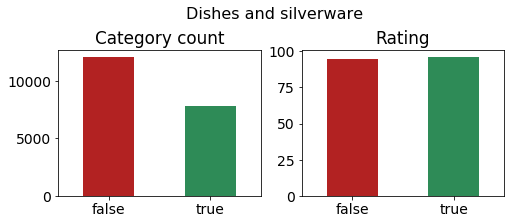


There are 17202 without Other pet(s), with a mean rating of 95.22793861178933
There are 54 with Other pet(s), with a mean rating of 94.72222222222223
P-value is 6.29e-01

There are 16630 without Pocket wifi, with a mean rating of 95.19951894167168
There are 626 with Pocket wifi, with a mean rating of 95.93929712460064
P-value is 4.66e-01

There are 17201 without Electric profiling bed, with a mean rating of 95.2198128015813
There are 55 with Electric profiling bed, with a mean rating of 97.27272727272727
P-value is 4.33e-01

There are 16816 without Outlet covers, with a mean rating of 95.17364414843007
There are 440 with Outlet covers, with a mean rating of 97.24090909090908
P-value is 1.25e-04
Effect is significant! Here's a plot:


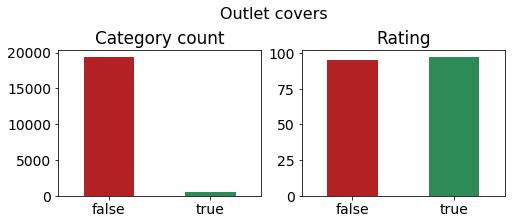

C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\KlaasjanOuwens\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



There are 17255 without Full kitchen, with a mean rating of 95.22607939727615
There are 1 with Full kitchen, with a mean rating of 100.0
P-value is    nan

There are 11326 without Stove, with a mean rating of 94.77123432809465
There are 5930 with Stove, with a mean rating of 96.0956155143339
P-value is 6.21e-11
Effect is significant! Here's a plot:


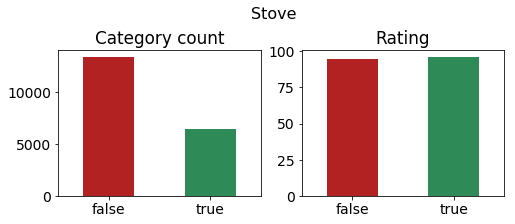


There are 17171 without Fireplace guards, with a mean rating of 95.21338302952653
There are 85 with Fireplace guards, with a mean rating of 97.84705882352941
P-value is 3.44e-09
Effect is significant! Here's a plot:


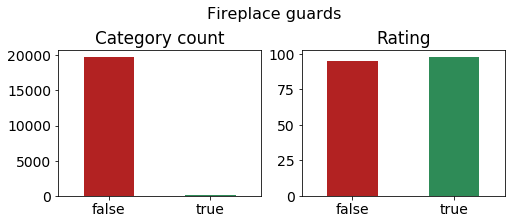


There are 17241 without Fixed grab bars for toilet, with a mean rating of 95.22817701989443
There are 15 with Fixed grab bars for toilet, with a mean rating of 93.13333333333334
P-value is 6.78e-01

There are 16373 without Pets live on this property, with a mean rating of 95.21559885176815
There are 883 with Pets live on this property, with a mean rating of 95.42582106455266
P-value is 3.81e-02

There are 499 without Heating, with a mean rating of 93.14028056112224
There are 16757 with Heating, with a mean rating of 95.28847645759981
P-value is 7.82e-01

There are 13579 without translation missing: en.hosting_amenity_50, with a mean rating of 95.26688268650122
There are 3677 with translation missing: en.hosting_amenity_50, with a mean rating of 95.0766929562143
P-value is 2.45e-24
Effect is significant! Here's a plot:


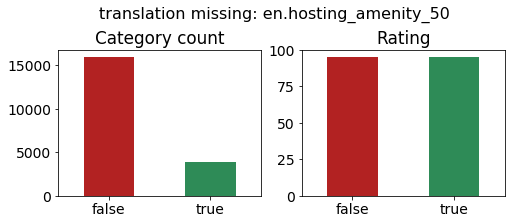


There are 15822 without Paid parking on premises, with a mean rating of 95.12925041082038
There are 1434 with Paid parking on premises, with a mean rating of 96.29776847977685
P-value is 5.18e-01

There are 16298 without Wide hallways, with a mean rating of 95.13829917781322
There are 958 with Wide hallways, with a mean rating of 96.72442588726514
P-value is 1.83e-01

There are 10007 without Fire extinguisher, with a mean rating of 95.04866593384631
There are 7249 with Fire extinguisher, with a mean rating of 95.47165126224307
P-value is 1.06e-26
Effect is significant! Here's a plot:


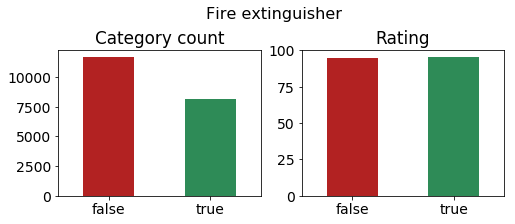


There are 17191 without Table corner guards, with a mean rating of 95.21650863824094
There are 65 with Table corner guards, with a mean rating of 97.83076923076923
P-value is 1.40e-02

There are 11151 without Bed linens, with a mean rating of 95.0598152632051
There are 6105 with Bed linens, with a mean rating of 95.53054873054873
P-value is 3.43e-06
Effect is significant! Here's a plot:


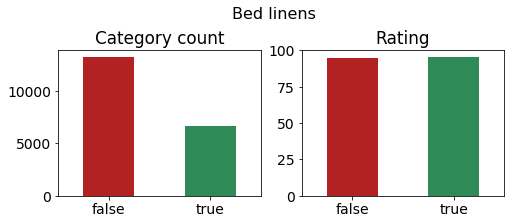


There are 17249 without Ski-in/Ski-out, with a mean rating of 95.22725955127834
There are 7 with Ski-in/Ski-out, with a mean rating of 93.0
P-value is 5.87e-01

There are 523 without Essentials, with a mean rating of 92.87571701720842
There are 16733 with Essentials, with a mean rating of 95.29982668977469
P-value is 3.17e-02

There are 11377 without Oven, with a mean rating of 94.76601916146612
There are 5879 with Oven, with a mean rating of 96.11719680217725
P-value is 6.37e-17
Effect is significant! Here's a plot:


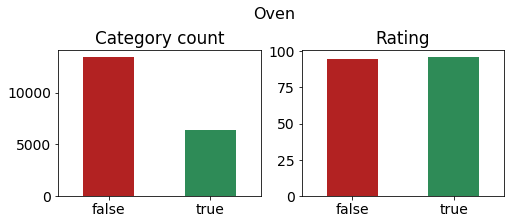


There are 17062 without Building staff, with a mean rating of 95.22095885593717
There are 194 with Building staff, with a mean rating of 95.70103092783505
P-value is 2.90e-01

There are 16428 without Air conditioning, with a mean rating of 95.22869491112735
There are 828 with Air conditioning, with a mean rating of 95.17995169082126
P-value is 8.77e-42
Effect is significant! Here's a plot:


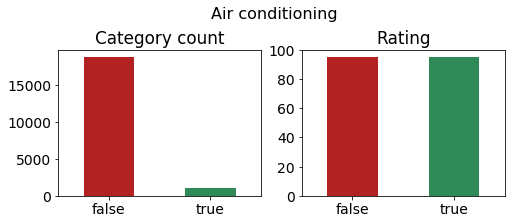


There are 16659 without Changing table, with a mean rating of 95.15445104748184
There are 597 with Changing table, with a mean rating of 97.23283082077052
P-value is 7.09e-08
Effect is significant! Here's a plot:


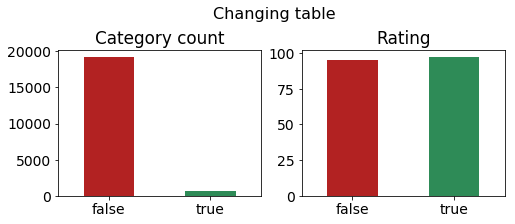


There are 16493 without Wheelchair accessible, with a mean rating of 95.24216334202389
There are 763 with Wheelchair accessible, with a mean rating of 94.88466579292268
P-value is 4.98e-02

There are 14409 without Extra pillows and blankets, with a mean rating of 95.04337566798529
There are 2847 with Extra pillows and blankets, with a mean rating of 96.1524411661398
P-value is 9.71e-13
Effect is significant! Here's a plot:


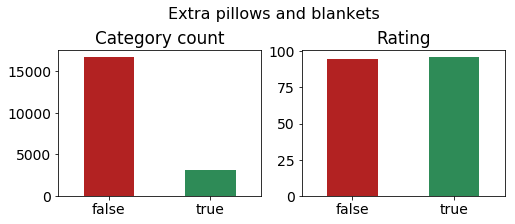


There are 17015 without Wide clearance to shower, with a mean rating of 95.20393770202762
There are 241 with Wide clearance to shower, with a mean rating of 96.80912863070539
P-value is 7.20e-02

There are 16658 without Cat(s), with a mean rating of 95.21605234722055
There are 598 with Cat(s), with a mean rating of 95.5133779264214
P-value is 3.73e-01

There are 17079 without Gym, with a mean rating of 95.23203934656595
There are 177 with Gym, with a mean rating of 94.67796610169492
P-value is 1.87e-11
Effect is significant! Here's a plot:


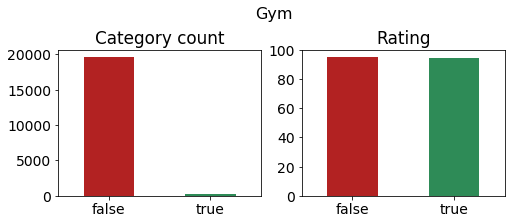


There are 16401 without Lockbox, with a mean rating of 95.1843790012804
There are 855 with Lockbox, with a mean rating of 96.03157894736842
P-value is 2.99e-01

There are 4713 without Hangers, with a mean rating of 94.63377890939954
There are 12543 with Hangers, with a mean rating of 95.44901538706848
P-value is 2.37e-07
Effect is significant! Here's a plot:


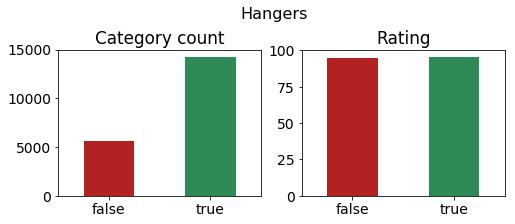


There are 17218 without Hot water kettle, with a mean rating of 95.2233708909281
There are 38 with Hot water kettle, with a mean rating of 96.57894736842105
P-value is 4.66e-01

There are 16298 without Wide entrance for guests, with a mean rating of 95.1332065284084
There are 958 with Wide entrance for guests, with a mean rating of 96.81106471816284
P-value is 6.68e-02

There are 17062 without Step-free shower, with a mean rating of 95.23033642011488
There are 194 with Step-free shower, with a mean rating of 94.87628865979381
P-value is 6.44e-02

There are 16707 without Babysitter recommendations, with a mean rating of 95.17154486143532
There are 549 with Babysitter recommendations, with a mean rating of 96.89435336976321
P-value is 2.10e-15
Effect is significant! Here's a plot:


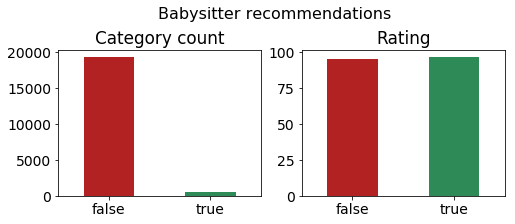


There are 16561 without Ethernet connection, with a mean rating of 95.17571402693073
There are 695 with Ethernet connection, with a mean rating of 96.43309352517986
P-value is 2.06e-01

There are 16908 without Game console, with a mean rating of 95.20682517151644
There are 348 with Game console, with a mean rating of 96.17528735632185
P-value is 1.96e-09
Effect is significant! Here's a plot:


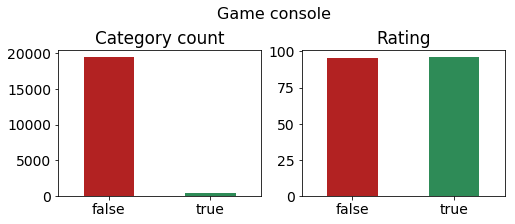


There are 16331 without Indoor fireplace, with a mean rating of 95.16306411119956
There are 925 with Indoor fireplace, with a mean rating of 96.34378378378378
P-value is 1.76e-55
Effect is significant! Here's a plot:


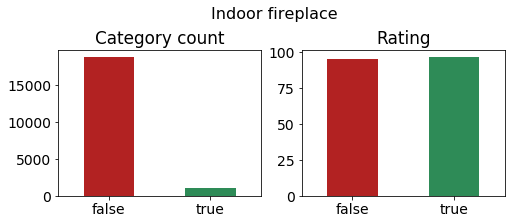


There are 16109 without Wide entrance, with a mean rating of 95.11509094295114
There are 1147 with Wide entrance, with a mean rating of 96.78901482127289
P-value is 3.94e-02

There are 16900 without Cleaning before checkout, with a mean rating of 95.22408284023669
There are 356 with Cleaning before checkout, with a mean rating of 95.33426966292134
P-value is 2.48e-01

There are 15741 without No stairs or steps to enter, with a mean rating of 95.0968172288927
There are 1515 with No stairs or steps to enter, with a mean rating of 96.57227722772278
P-value is 2.64e-01

There are 11146 without Cooking basics, with a mean rating of 94.67539924636641
There are 6110 with Cooking basics, with a mean rating of 96.23142389525368
P-value is 5.36e-13
Effect is significant! Here's a plot:


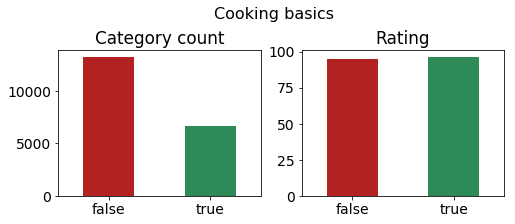


There are 16343 without Children’s dinnerware, with a mean rating of 95.12825062717984
There are 913 with Children’s dinnerware, with a mean rating of 96.98247535596933
P-value is 9.97e-16
Effect is significant! Here's a plot:



There are 16514 without BBQ grill, with a mean rating of 95.15750272496064
There are 742 with BBQ grill, with a mean rating of 96.75876010781671
P-value is 6.27e-08
Effect is significant! Here's a plot:



There are 9740 without Refrigerator, with a mean rating of 94.63162217659138
There are 7516 with Refrigerator, with a mean rating of 95.99707291112294
P-value is 6.19e-10
Effect is significant! Here's a plot:


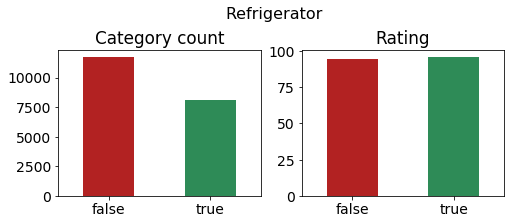


There are 17146 without Smart lock, with a mean rating of 95.21905983902951
There are 110 with Smart lock, with a mean rating of 96.36363636363636
P-value is 7.30e-02

There are 17255 without Pool with pool hoist, with a mean rating of 95.22671689365401
There are 1 with Pool with pool hoist, with a mean rating of 89.0
P-value is    nan

There are 5482 without Iron, with a mean rating of 93.9325063845312
There are 11774 with Iron, with a mean rating of 95.82877526753865
P-value is 1.21e-17
Effect is significant! Here's a plot:



There are 15620 without Elevator, with a mean rating of 95.22874519846351
There are 1636 with Elevator, with a mean rating of 95.20354523227384
P-value is 5.91e-01

There are 17153 without Keypad, with a mean rating of 95.22369264851629
There are 103 with Keypad, with a mean rating of 95.66990291262135
P-value is 9.48e-01

There are 16250 without Crib, with a mean rating of 95.15938461538461
There are 1006 with Crib, with a mean rating of 96.30815109343936
P-value is 5.46e-13
Effect is significant! Here's a plot:


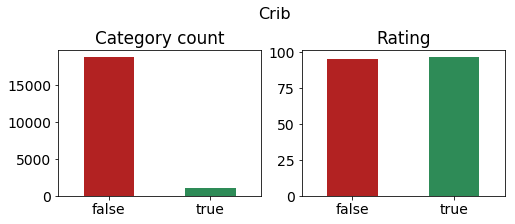


There are 15913 without Single level home, with a mean rating of 95.11374348017344
There are 1343 with Single level home, with a mean rating of 96.56068503350707
P-value is 4.98e-01

There are 16594 without Extra space around bed, with a mean rating of 95.16698806797638
There are 662 with Extra space around bed, with a mean rating of 96.71450151057402
P-value is 8.85e-04

There are 16480 without Flat path to guest entrance, with a mean rating of 95.15430825242719
There are 776 with Flat path to guest entrance, with a mean rating of 96.75644329896907
P-value is 7.39e-01

There are 9991 without Carbon monoxide detector, with a mean rating of 94.81563407066359
There are 7265 with Carbon monoxide detector, with a mean rating of 95.79119064005506
P-value is 7.47e-09
Effect is significant! Here's a plot:


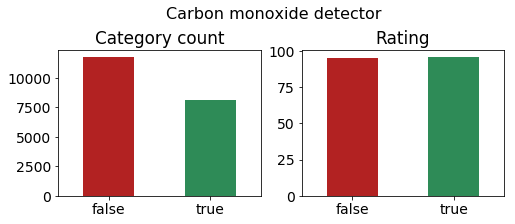


There are 3855 without TV, with a mean rating of 94.34474708171206
There are 13401 with TV, with a mean rating of 95.47996418177748
P-value is 4.12e-37
Effect is significant! Here's a plot:


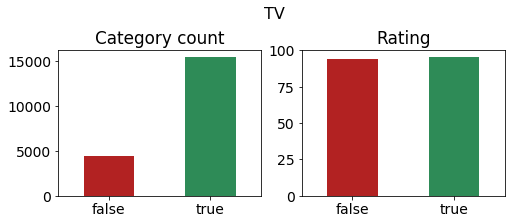


There are 17196 without Beach essentials, with a mean rating of 95.22167946033962
There are 60 with Beach essentials, with a mean rating of 96.56666666666666
P-value is 1.60e-01

There are 17254 without Private bathroom, with a mean rating of 95.2260925002898
There are 2 with Private bathroom, with a mean rating of 97.5
P-value is 6.28e-01

There are 16880 without Stair gates, with a mean rating of 95.18080568720379
There are 376 with Stair gates, with a mean rating of 97.27127659574468
P-value is 6.23e-08
Effect is significant! Here's a plot:


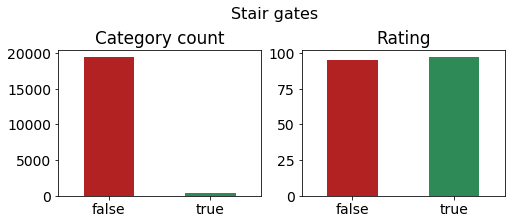


There are 14312 without Luggage dropoff allowed, with a mean rating of 95.00880380100615
There are 2944 with Luggage dropoff allowed, with a mean rating of 96.28396739130434
P-value is 8.07e-21
Effect is significant! Here's a plot:



There are 17246 without Trash can, with a mean rating of 95.22503768989911
There are 10 with Trash can, with a mean rating of 97.5
P-value is 4.77e-01

There are 17117 without Suitable for events, with a mean rating of 95.24011216918852
There are 139 with Suitable for events, with a mean rating of 93.53237410071942
P-value is 3.21e-45
Effect is significant! Here's a plot:


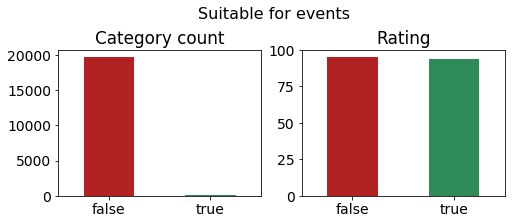


There are 16198 without Smoking allowed, with a mean rating of 95.33831337202123
There are 1058 with Smoking allowed, with a mean rating of 93.51228733459357
P-value is 2.00e-01

There are 11992 without Dishwasher, with a mean rating of 94.79719813208806
There are 5264 with Dishwasher, with a mean rating of 96.2040273556231
P-value is 1.17e-23
Effect is significant! Here's a plot:


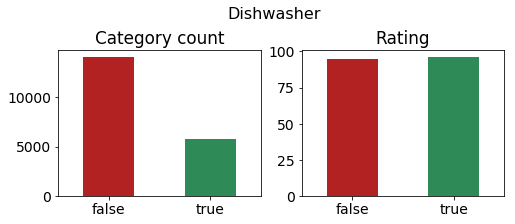


There are 17142 without Accessible-height toilet, with a mean rating of 95.21928596429821
There are 114 with Accessible-height toilet, with a mean rating of 96.28947368421052
P-value is 4.97e-01

There are 11474 without Private entrance, with a mean rating of 94.93472198012898
There are 5782 with Private entrance, with a mean rating of 95.80508474576271
P-value is 1.17e-31
Effect is significant! Here's a plot:


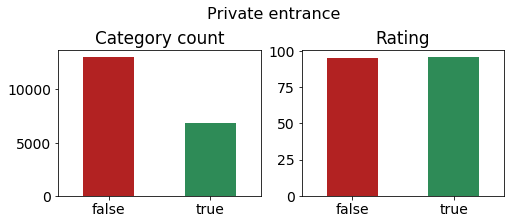


There are 17241 without Bathtub with bath chair, with a mean rating of 95.22614697523346
There are 15 with Bathtub with bath chair, with a mean rating of 95.46666666666667
P-value is 3.06e-01

There are 16386 without Handheld shower head, with a mean rating of 95.17380690833639
There are 870 with Handheld shower head, with a mean rating of 96.21609195402299
P-value is 1.64e-05
Effect is significant! Here's a plot:


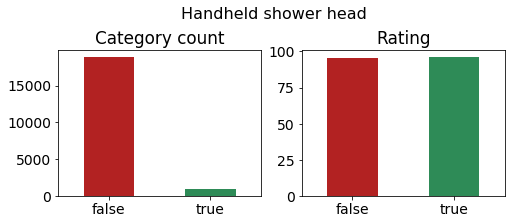


There are 14686 without Private living room, with a mean rating of 95.08034863134958
There are 2570 with Private living room, with a mean rating of 96.06070038910507
P-value is 3.87e-05
Effect is significant! Here's a plot:


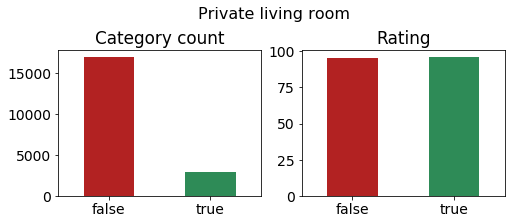


There are 16753 without Wide entryway, with a mean rating of 95.18014683937206
There are 503 with Wide entryway, with a mean rating of 96.76540755467197
P-value is 2.80e-03

There are 17256 without Roll-in shower with chair, with a mean rating of 95.22635605006954
There are 0 with Roll-in shower with chair, with a mean rating of nan
P-value is    nan

There are 17126 without Dog(s), with a mean rating of 95.22550507999533
There are 130 with Dog(s), with a mean rating of 95.33846153846154
P-value is 4.66e-02

There are 15958 without Pets allowed, with a mean rating of 95.23204662238376
There are 1298 with Pets allowed, with a mean rating of 95.15639445300462
P-value is 4.15e-04
Effect is significant! Here's a plot:


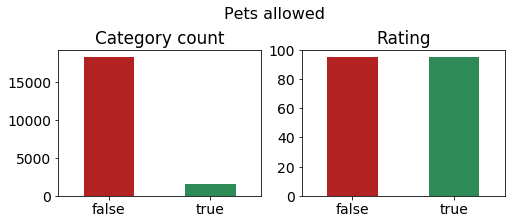


There are 17255 without Washer / Dryer, with a mean rating of 95.22642712257317
There are 1 with Washer / Dryer, with a mean rating of 94.0
P-value is 7.10e-02

There are 17206 without Doorman, with a mean rating of 95.22596768569103
There are 50 with Doorman, with a mean rating of 95.36
P-value is 5.77e-01

There are 17233 without Shower chair, with a mean rating of 95.2241629431904
There are 23 with Shower chair, with a mean rating of 96.8695652173913
P-value is 3.84e-02

There are 16820 without Hot tub, with a mean rating of 95.2256837098692
There are 436 with Hot tub, with a mean rating of 95.25229357798165
P-value is 1.09e-08
Effect is significant! Here's a plot:



There are 12040 without Host greets you, with a mean rating of 94.75182724252491
There are 5216 with Host greets you, with a mean rating of 96.32170245398773
P-value is 3.84e-01

There are 10735 without Cable TV, with a mean rating of 95.09278062412669
There are 6521 with Cable TV, with a mean rating of 95.44625057506518
P-value is 1.43e-15
Effect is significant! Here's a plot:



There are 15816 without Well-lit path to entrance, with a mean rating of 95.10748609003541
There are 1440 with Well-lit path to entrance, with a mean rating of 96.53194444444445
P-value is 9.43e-01

There are 17255 without Bread maker, with a mean rating of 95.22648507678933
There are 1 with Bread maker, with a mean rating of 93.0
P-value is    nan

There are 17254 without Ceiling hoist, with a mean rating of 95.22644024574012
There are 2 with Ceiling hoist, with a mean rating of 94.5
P-value is 9.20e-01

There are 17224 without Fixed grab bars for shower, with a mean rating of 95.22590571295866
There are 32 with Fixed grab bars for shower, with a mean rating of 95.46875
P-value is 6.76e-01

There are 16353 without Accessible-height bed, with a mean rating of 95.15942028985508
There are 903 with Accessible-height bed, with a mean rating of 96.43853820598007
P-value is 1.53e-01

There are 16638 without Pack ’n Play/travel crib, with a mean rating of 95.17520134631566
There are 618 with

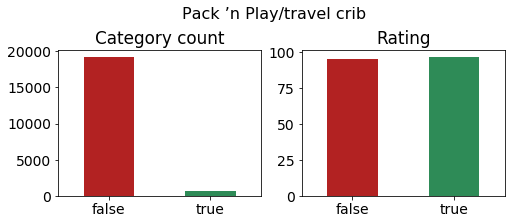


There are 17048 without Window guards, with a mean rating of 95.24266776161427
There are 208 with Window guards, with a mean rating of 93.88942307692308
P-value is 1.38e-02

There are 14324 without translation missing: en.hosting_amenity_49, with a mean rating of 95.19072884669087
There are 2932 with translation missing: en.hosting_amenity_49, with a mean rating of 95.40040927694406
P-value is 2.06e-30
Effect is significant! Here's a plot:



There are 15826 without High chair, with a mean rating of 95.05806900037912
There are 1430 with High chair, with a mean rating of 97.08881118881119
P-value is 6.68e-19
Effect is significant! Here's a plot:


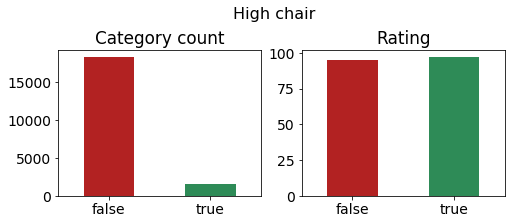


There are 16935 without toilet, with a mean rating of 95.20124003542958
There are 321 with toilet, with a mean rating of 96.55140186915888
P-value is 2.42e-01

There are 16739 without Baby bath, with a mean rating of 95.17103769639763
There are 517 with Baby bath, with a mean rating of 97.0174081237911
P-value is 9.04e-05
Effect is significant! Here's a plot:


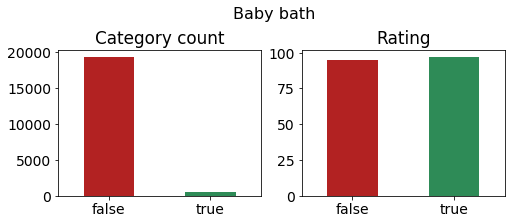


There are 5374 without Laptop friendly workspace, with a mean rating of 94.49367324153332
There are 11882 with Laptop friendly workspace, with a mean rating of 95.55773438815014
P-value is 2.93e-06
Effect is significant! Here's a plot:


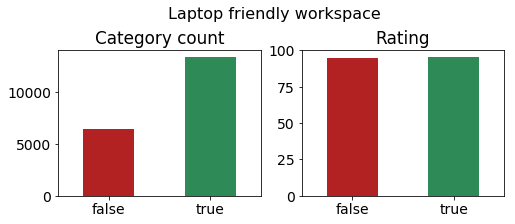


There are 15730 without 24-hour check-in, with a mean rating of 95.3085187539733
There are 1526 with 24-hour check-in, with a mean rating of 94.37942332896462
P-value is 2.18e-01

There are 17008 without Baby monitor, with a mean rating of 95.19402634054562
There are 248 with Baby monitor, with a mean rating of 97.44354838709677
P-value is 2.09e-07
Effect is significant! Here's a plot:


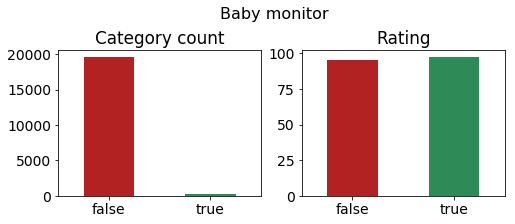

In [35]:
# Plot counts, mean rating and calculate t-test P-value for every amenity
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
result = [binary_count_and_rating_plot(col) for col in df.iloc[:,44:-1].columns]


P-value is 3.58e-08
There are 9514 without Hot water, with a median price of 125.0
There are 10353 with Hot water, with a median price of 140.0
Effect is significant!


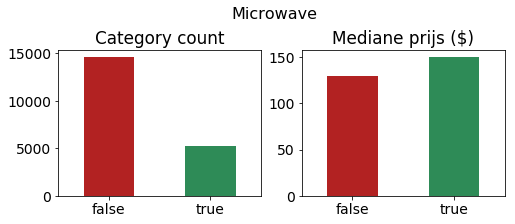


P-value is 5.42e-12
There are 14601 without Microwave, with a median price of 129.0
There are 5266 with Microwave, with a median price of 150.0
Effect is significant!


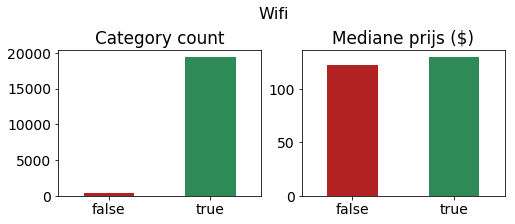


P-value is 1.89e-01
There are 448 without Wifi, with a median price of 122.5
There are 19419 with Wifi, with a median price of 130.0


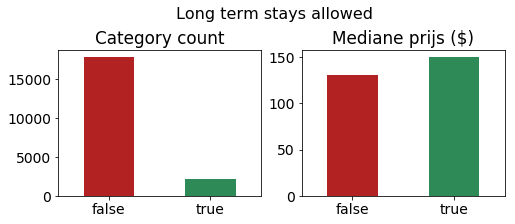


P-value is 6.19e-20
There are 17779 without Long term stays allowed, with a median price of 130.0
There are 2088 with Long term stays allowed, with a median price of 150.0
Effect is significant!


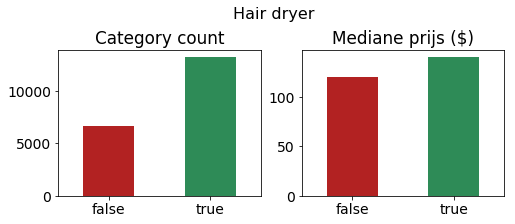


P-value is 8.35e-12
There are 6658 without Hair dryer, with a median price of 120.0
There are 13209 with Hair dryer, with a median price of 140.0
Effect is significant!



P-value is 7.38e-37
There are 18155 without Bathtub, with a median price of 129.0
There are 1712 with Bathtub, with a median price of 180.0
Effect is significant!



P-value is 3.35e-01
There are 19573 without EV charger, with a median price of 130.0
There are 294 with EV charger, with a median price of 149.0



P-value is 4.00e-16
There are 18770 without Waterfront, with a median price of 130.0
There are 1097 with Waterfront, with a median price of 155.0
Effect is significant!



P-value is 1.21e-37
There are 11039 without Dryer, with a median price of 120.0
There are 8828 with Dryer, with a median price of 150.0
Effect is significant!


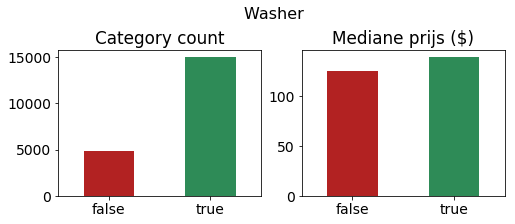


P-value is 4.73e-02
There are 4840 without Washer, with a median price of 125.0
There are 15027 with Washer, with a median price of 139.0



P-value is 9.08e-01
There are 16869 without Lock on bedroom door, with a median price of 135.0
There are 2998 with Lock on bedroom door, with a median price of 118.0



P-value is 4.94e-01
There are 6489 without Shampoo, with a median price of 128.0
There are 13378 with Shampoo, with a median price of 135.0


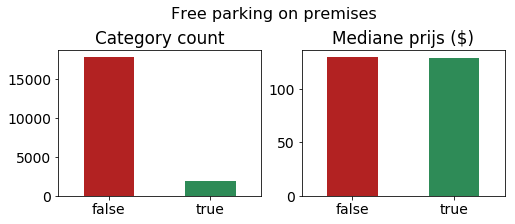


P-value is 9.15e-01
There are 17896 without Free parking on premises, with a median price of 130.0
There are 1971 with Free parking on premises, with a median price of 129.0


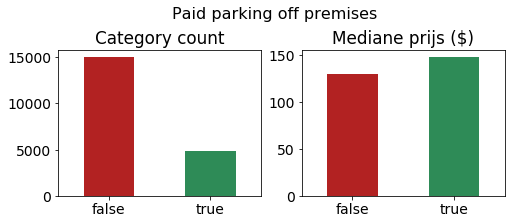


P-value is 1.32e-04
There are 15039 without Paid parking off premises, with a median price of 130.0
There are 4828 with Paid parking off premises, with a median price of 148.0
Effect is significant!



P-value is 8.74e-01
There are 19860 without Ground floor access, with a median price of 130.0
There are 7 with Ground floor access, with a median price of 125.0



P-value is 1.04e-10
There are 17651 without Safety card, with a median price of 130.0
There are 2216 with Safety card, with a median price of 140.0
Effect is significant!


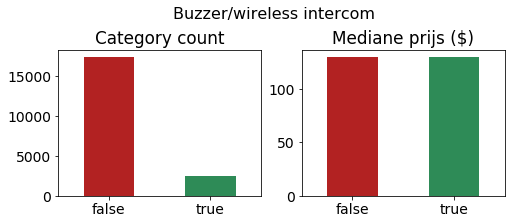


P-value is 5.76e-02
There are 17339 without Buzzer/wireless intercom, with a median price of 130.0
There are 2528 with Buzzer/wireless intercom, with a median price of 130.0


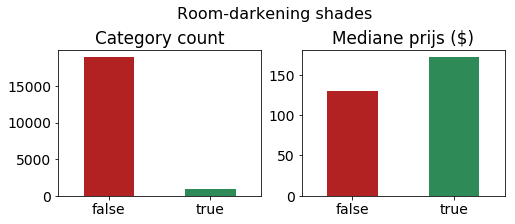


P-value is 5.13e-11
There are 18960 without Room-darkening shades, with a median price of 130.0
There are 907 with Room-darkening shades, with a median price of 172.0
Effect is significant!



P-value is 4.41e-02
There are 13400 without Internet, with a median price of 135.0
There are 6467 with Internet, with a median price of 129.0



P-value is 1.97e-18
There are 18058 without Children’s books and toys, with a median price of 129.0
There are 1809 with Children’s books and toys, with a median price of 175.0
Effect is significant!



P-value is 2.76e-01
There are 19715 without Disabled parking spot, with a median price of 130.0
There are 152 with Disabled parking spot, with a median price of 159.0



P-value is 9.69e-01
There are 19822 without Beachfront, with a median price of 130.0
There are 45 with Beachfront, with a median price of 145.0


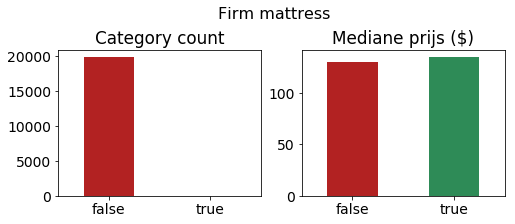


P-value is 2.86e-01
There are 19843 without Firm mattress, with a median price of 130.0
There are 24 with Firm mattress, with a median price of 135.0


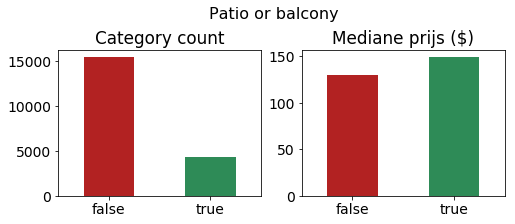


P-value is 1.62e-03
There are 15494 without Patio or balcony, with a median price of 130.0
There are 4373 with Patio or balcony, with a median price of 149.0



P-value is 3.05e-02
There are 19454 without Wide doorway to guest bathroom, with a median price of 130.0
There are 413 with Wide doorway to guest bathroom, with a median price of 150.0



P-value is 2.31e-03
There are 18021 without Garden or backyard, with a median price of 130.0
There are 1846 with Garden or backyard, with a median price of 150.0


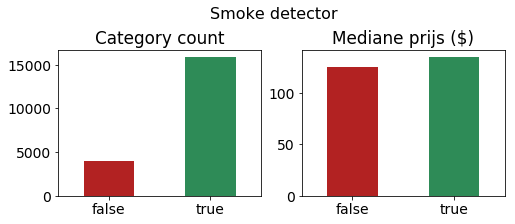


P-value is 7.03e-08
There are 3966 without Smoke detector, with a median price of 125.0
There are 15901 with Smoke detector, with a median price of 135.0
Effect is significant!



P-value is 6.65e-02
There are 18567 without Self check-in, with a median price of 130.0
There are 1300 with Self check-in, with a median price of 140.0



P-value is 1.23e-01
There are 19010 without Free street parking, with a median price of 134.0
There are 857 with Free street parking, with a median price of 109.0



P-value is 4.96e-15
There are 12531 without Family/kid friendly, with a median price of 125.0
There are 7336 with Family/kid friendly, with a median price of 149.5
Effect is significant!


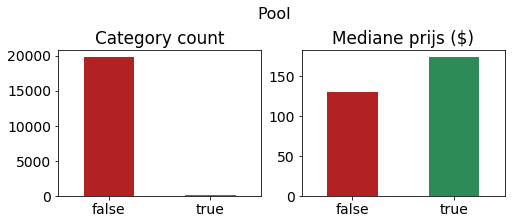


P-value is 9.43e-08
There are 19797 without Pool, with a median price of 130.0
There are 70 with Pool, with a median price of 174.5
Effect is significant!


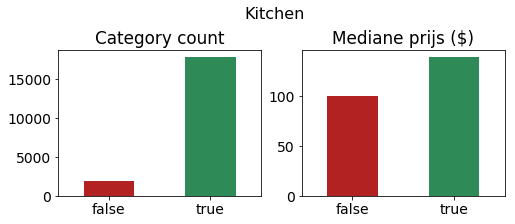


P-value is 1.86e-07
There are 1970 without Kitchen, with a median price of 100.0
There are 17897 with Kitchen, with a median price of 139.0
Effect is significant!


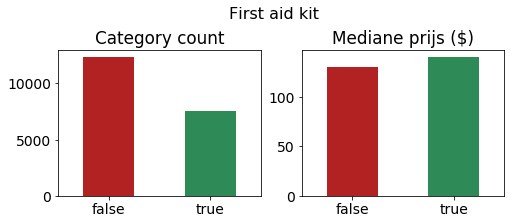


P-value is 3.33e-11
There are 12355 without First aid kit, with a median price of 130.0
There are 7512 with First aid kit, with a median price of 140.0
Effect is significant!



P-value is 2.26e-02
There are 19567 without Lake access, with a median price of 130.0
There are 300 with Lake access, with a median price of 130.0



P-value is 2.24e-09
There are 12743 without Coffee maker, with a median price of 125.0
There are 7124 with Coffee maker, with a median price of 149.0
Effect is significant!


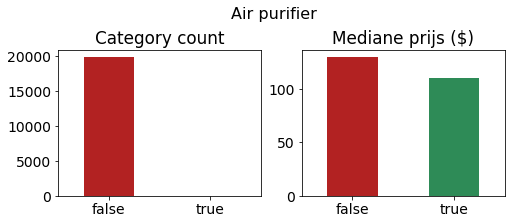


P-value is 8.52e-01
There are 19864 without Air purifier, with a median price of 130.0
There are 3 with Air purifier, with a median price of 110.0



P-value is 9.33e-01
There are 19865 without Mobile hoist, with a median price of 130.0
There are 2 with Mobile hoist, with a median price of 175.0



P-value is 1.67e-01
There are 18620 without Breakfast, with a median price of 133.5
There are 1247 with Breakfast, with a median price of 122.0


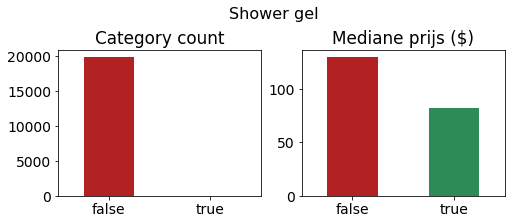


P-value is 3.07e-01
There are 19857 without Shower gel, with a median price of 130.0
There are 10 with Shower gel, with a median price of 82.5



P-value is 1.91e-05
There are 12060 without Dishes and silverware, with a median price of 125.0
There are 7807 with Dishes and silverware, with a median price of 145.0
Effect is significant!



P-value is 6.29e-01
There are 19809 without Other pet(s), with a median price of 130.0
There are 58 with Other pet(s), with a median price of 130.0



P-value is 4.66e-01
There are 19197 without Pocket wifi, with a median price of 130.0
There are 670 with Pocket wifi, with a median price of 145.0


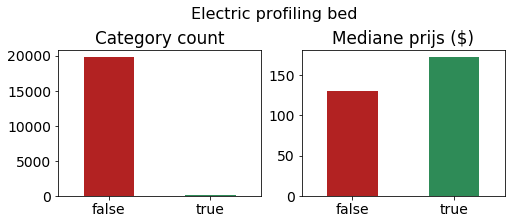


P-value is 4.33e-01
There are 19805 without Electric profiling bed, with a median price of 130.0
There are 62 with Electric profiling bed, with a median price of 172.5


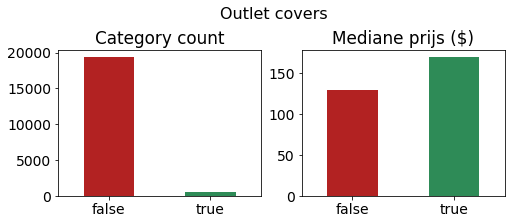


P-value is 1.25e-04
There are 19387 without Outlet covers, with a median price of 130.0
There are 480 with Outlet covers, with a median price of 170.0
Effect is significant!



P-value is    nan
There are 19866 without Full kitchen, with a median price of 130.0
There are 1 with Full kitchen, with a median price of 170.0


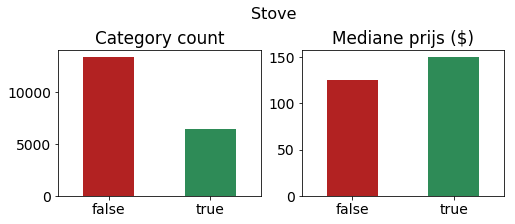


P-value is 6.21e-11
There are 13419 without Stove, with a median price of 125.0
There are 6448 with Stove, with a median price of 150.0
Effect is significant!


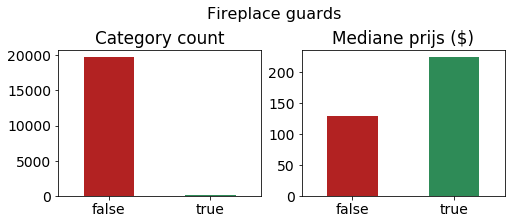


P-value is 3.44e-09
There are 19776 without Fireplace guards, with a median price of 130.0
There are 91 with Fireplace guards, with a median price of 225.0
Effect is significant!


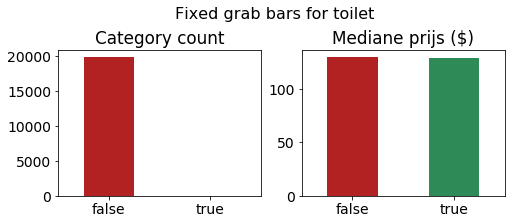


P-value is 6.78e-01
There are 19850 without Fixed grab bars for toilet, with a median price of 130.0
There are 17 with Fixed grab bars for toilet, with a median price of 129.0


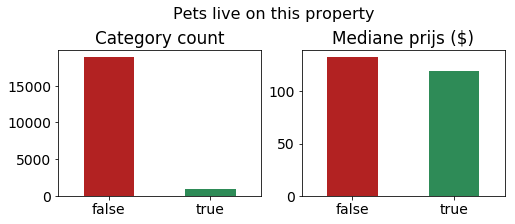


P-value is 3.81e-02
There are 18901 without Pets live on this property, with a median price of 133.0
There are 966 with Pets live on this property, with a median price of 120.0


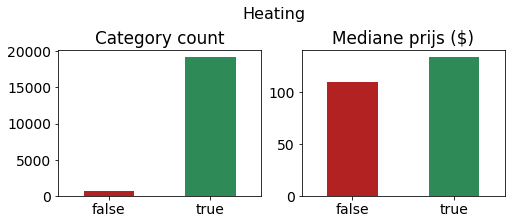


P-value is 7.82e-01
There are 646 without Heating, with a median price of 110.0
There are 19221 with Heating, with a median price of 134.0


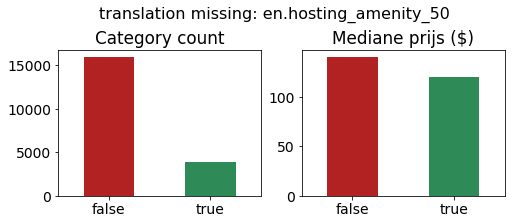


P-value is 2.45e-24
There are 15968 without translation missing: en.hosting_amenity_50, with a median price of 140.0
There are 3899 with translation missing: en.hosting_amenity_50, with a median price of 120.0
Effect is significant!


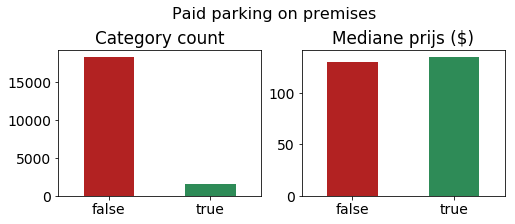


P-value is 5.18e-01
There are 18334 without Paid parking on premises, with a median price of 130.0
There are 1533 with Paid parking on premises, with a median price of 135.0



P-value is 1.83e-01
There are 18845 without Wide hallways, with a median price of 130.0
There are 1022 with Wide hallways, with a median price of 149.0


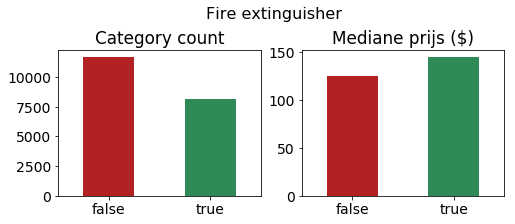


P-value is 1.06e-26
There are 11699 without Fire extinguisher, with a median price of 125.0
There are 8168 with Fire extinguisher, with a median price of 145.0
Effect is significant!


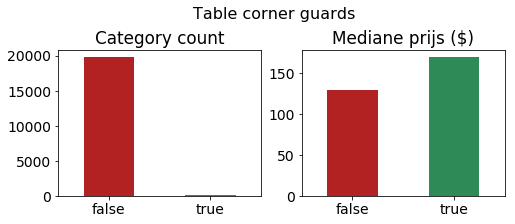


P-value is 1.40e-02
There are 19800 without Table corner guards, with a median price of 130.0
There are 67 with Table corner guards, with a median price of 170.0


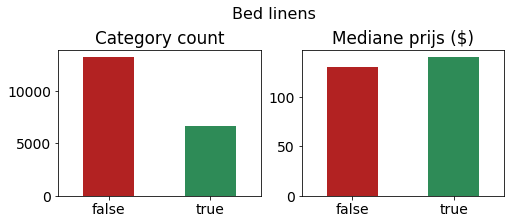


P-value is 3.43e-06
There are 13227 without Bed linens, with a median price of 130.0
There are 6640 with Bed linens, with a median price of 140.0
Effect is significant!



P-value is 5.87e-01
There are 19860 without Ski-in/Ski-out, with a median price of 130.0
There are 7 with Ski-in/Ski-out, with a median price of 140.0


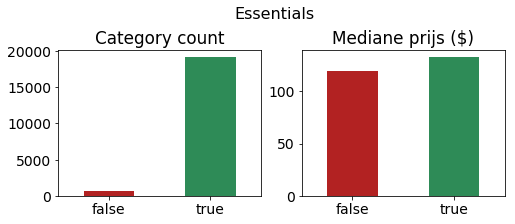


P-value is 3.17e-02
There are 664 without Essentials, with a median price of 120.0
There are 19203 with Essentials, with a median price of 133.0


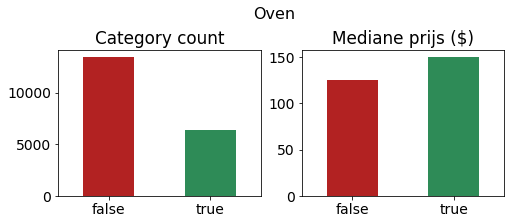


P-value is 6.37e-17
There are 13455 without Oven, with a median price of 125.0
There are 6412 with Oven, with a median price of 150.0
Effect is significant!


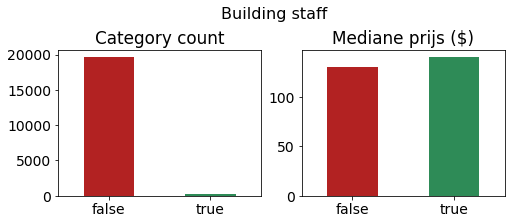


P-value is 2.90e-01
There are 19659 without Building staff, with a median price of 130.0
There are 208 with Building staff, with a median price of 140.0


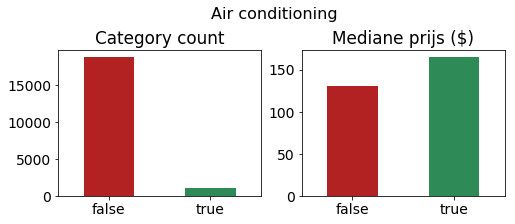


P-value is 8.77e-42
There are 18845 without Air conditioning, with a median price of 130.0
There are 1022 with Air conditioning, with a median price of 165.0
Effect is significant!


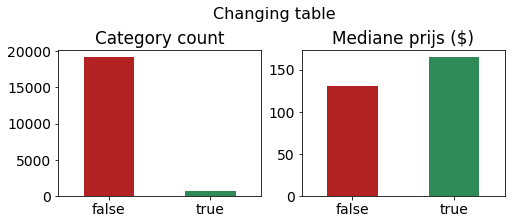


P-value is 7.09e-08
There are 19219 without Changing table, with a median price of 130.0
There are 648 with Changing table, with a median price of 165.0
Effect is significant!


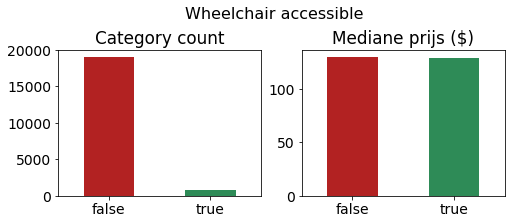


P-value is 4.98e-02
There are 19025 without Wheelchair accessible, with a median price of 130.0
There are 842 with Wheelchair accessible, with a median price of 129.0


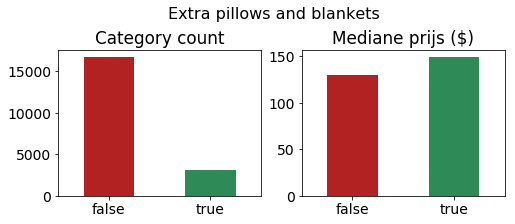


P-value is 9.71e-13
There are 16735 without Extra pillows and blankets, with a median price of 130.0
There are 3132 with Extra pillows and blankets, with a median price of 149.0
Effect is significant!


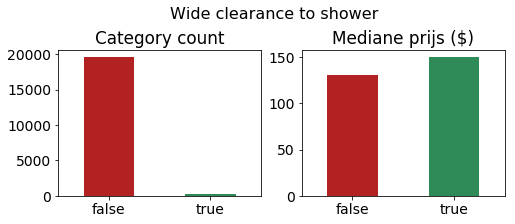


P-value is 7.20e-02
There are 19600 without Wide clearance to shower, with a median price of 130.0
There are 267 with Wide clearance to shower, with a median price of 150.0


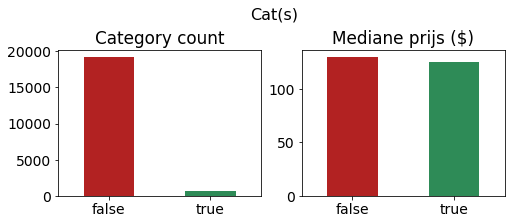


P-value is 3.73e-01
There are 19210 without Cat(s), with a median price of 130.0
There are 657 with Cat(s), with a median price of 125.0


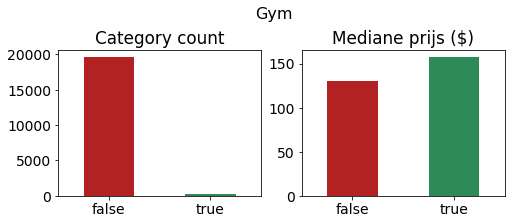


P-value is 1.87e-11
There are 19623 without Gym, with a median price of 130.0
There are 244 with Gym, with a median price of 157.5
Effect is significant!


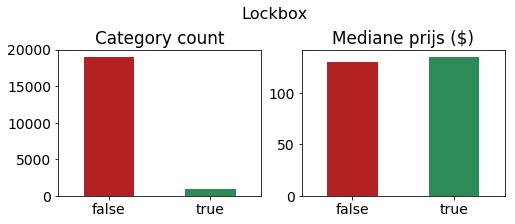


P-value is 2.99e-01
There are 18992 without Lockbox, with a median price of 130.0
There are 875 with Lockbox, with a median price of 135.0


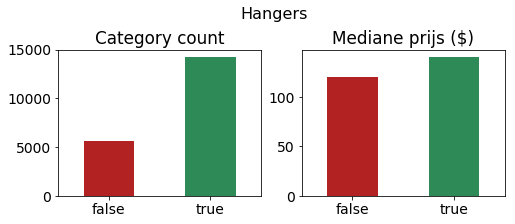


P-value is 2.37e-07
There are 5629 without Hangers, with a median price of 120.0
There are 14238 with Hangers, with a median price of 140.0
Effect is significant!


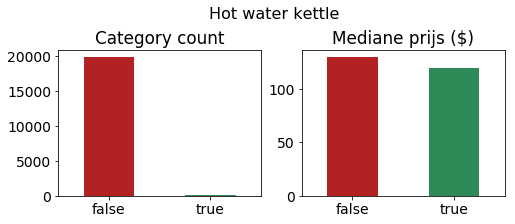


P-value is 4.66e-01
There are 19824 without Hot water kettle, with a median price of 130.0
There are 43 with Hot water kettle, with a median price of 120.0


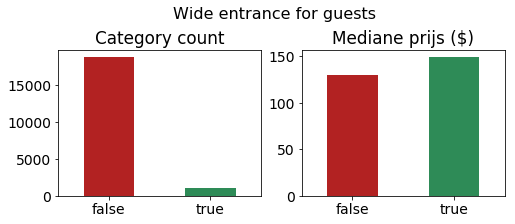


P-value is 6.68e-02
There are 18837 without Wide entrance for guests, with a median price of 130.0
There are 1030 with Wide entrance for guests, with a median price of 149.0


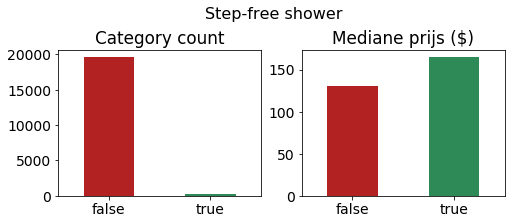


P-value is 6.44e-02
There are 19637 without Step-free shower, with a median price of 130.0
There are 230 with Step-free shower, with a median price of 165.0


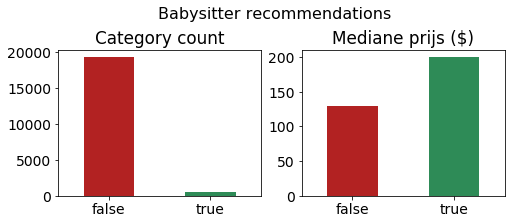


P-value is 2.10e-15
There are 19290 without Babysitter recommendations, with a median price of 130.0
There are 577 with Babysitter recommendations, with a median price of 200.0
Effect is significant!


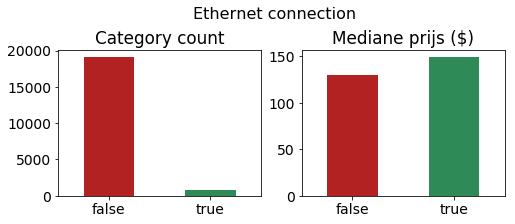


P-value is 2.06e-01
There are 19120 without Ethernet connection, with a median price of 130.0
There are 747 with Ethernet connection, with a median price of 149.0


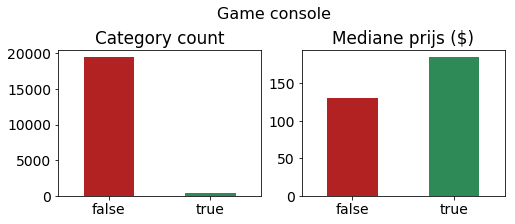


P-value is 1.96e-09
There are 19483 without Game console, with a median price of 130.0
There are 384 with Game console, with a median price of 185.0
Effect is significant!


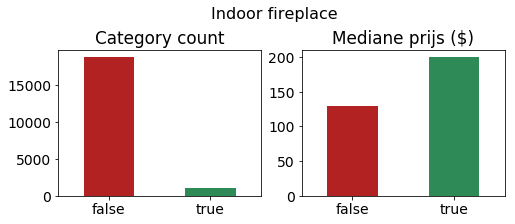


P-value is 1.76e-55
There are 18768 without Indoor fireplace, with a median price of 130.0
There are 1099 with Indoor fireplace, with a median price of 200.0
Effect is significant!


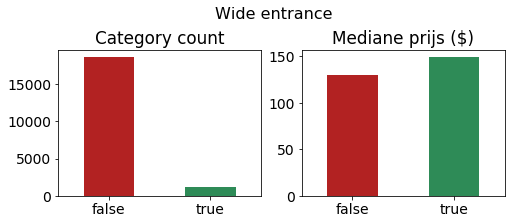


P-value is 3.94e-02
There are 18640 without Wide entrance, with a median price of 130.0
There are 1227 with Wide entrance, with a median price of 149.0


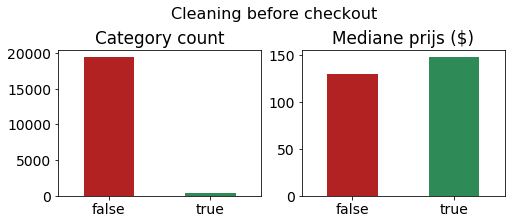


P-value is 2.48e-01
There are 19462 without Cleaning before checkout, with a median price of 130.0
There are 405 with Cleaning before checkout, with a median price of 148.0


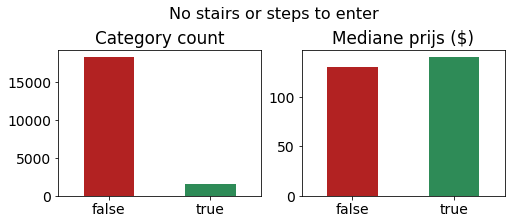


P-value is 2.64e-01
There are 18259 without No stairs or steps to enter, with a median price of 130.0
There are 1608 with No stairs or steps to enter, with a median price of 140.0


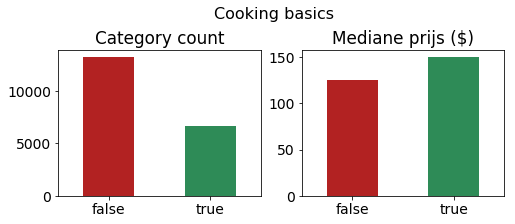


P-value is 5.36e-13
There are 13228 without Cooking basics, with a median price of 125.0
There are 6639 with Cooking basics, with a median price of 150.0
Effect is significant!


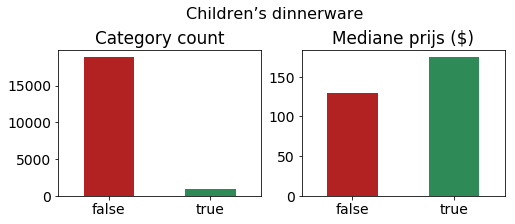


P-value is 9.97e-16
There are 18890 without Children’s dinnerware, with a median price of 130.0
There are 977 with Children’s dinnerware, with a median price of 175.0
Effect is significant!


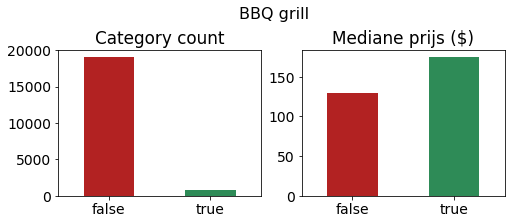


P-value is 6.27e-08
There are 19062 without BBQ grill, with a median price of 130.0
There are 805 with BBQ grill, with a median price of 175.0
Effect is significant!


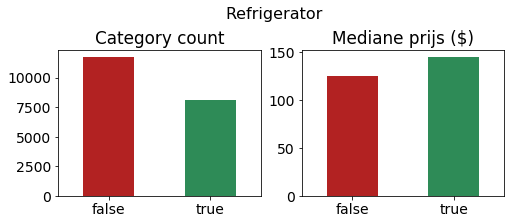


P-value is 6.19e-10
There are 11741 without Refrigerator, with a median price of 125.0
There are 8126 with Refrigerator, with a median price of 145.0
Effect is significant!


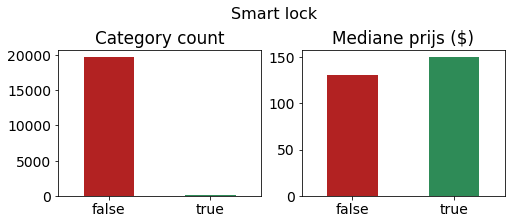


P-value is 7.30e-02
There are 19752 without Smart lock, with a median price of 130.0
There are 115 with Smart lock, with a median price of 150.0


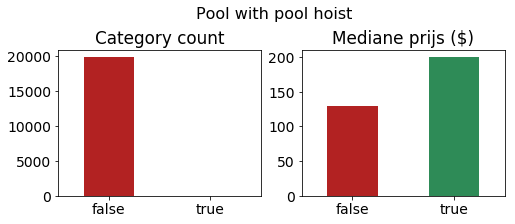


P-value is    nan
There are 19866 without Pool with pool hoist, with a median price of 130.0
There are 1 with Pool with pool hoist, with a median price of 200.0


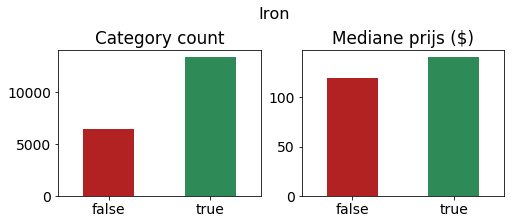


P-value is 1.21e-17
There are 6443 without Iron, with a median price of 120.0
There are 13424 with Iron, with a median price of 141.0
Effect is significant!


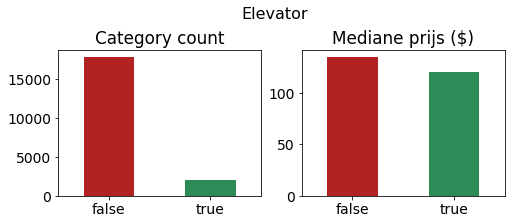


P-value is 5.91e-01
There are 17858 without Elevator, with a median price of 135.0
There are 2009 with Elevator, with a median price of 120.0


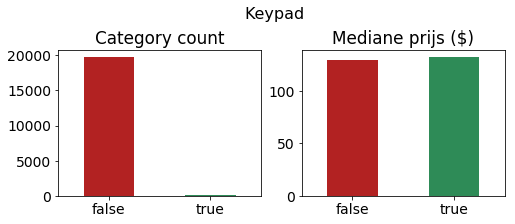


P-value is 9.48e-01
There are 19763 without Keypad, with a median price of 130.0
There are 104 with Keypad, with a median price of 132.5


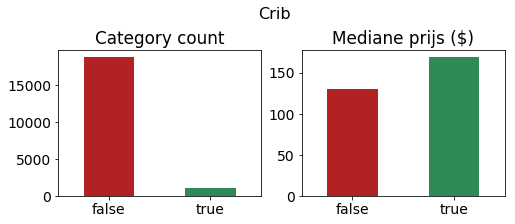


P-value is 5.46e-13
There are 18782 without Crib, with a median price of 130.0
There are 1085 with Crib, with a median price of 169.0
Effect is significant!


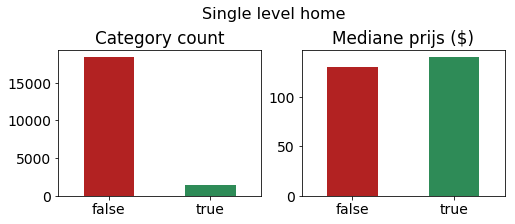


P-value is 4.98e-01
There are 18434 without Single level home, with a median price of 130.0
There are 1433 with Single level home, with a median price of 140.0


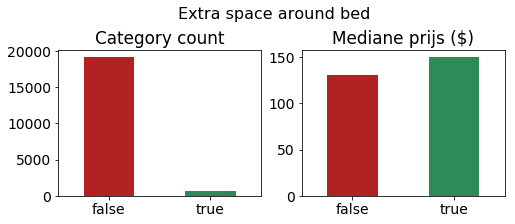


P-value is 8.85e-04
There are 19162 without Extra space around bed, with a median price of 130.0
There are 705 with Extra space around bed, with a median price of 150.0


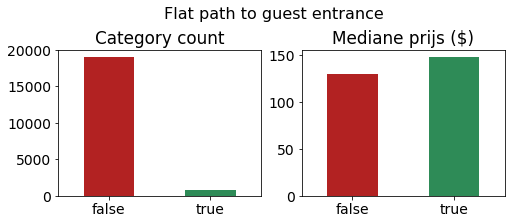


P-value is 7.39e-01
There are 19039 without Flat path to guest entrance, with a median price of 130.0
There are 828 with Flat path to guest entrance, with a median price of 148.0


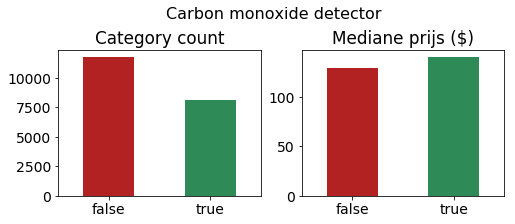


P-value is 7.47e-09
There are 11764 without Carbon monoxide detector, with a median price of 129.0
There are 8103 with Carbon monoxide detector, with a median price of 140.0
Effect is significant!


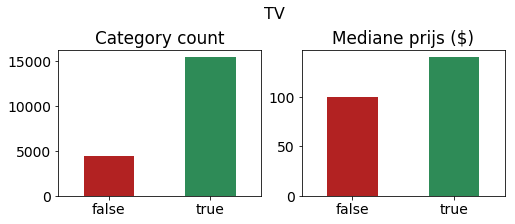


P-value is 4.12e-37
There are 4395 without TV, with a median price of 100.0
There are 15472 with TV, with a median price of 140.0
Effect is significant!


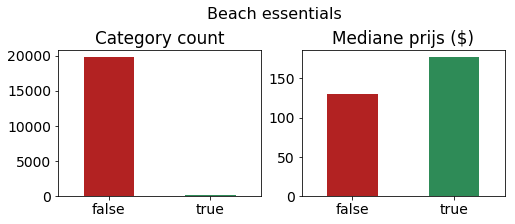


P-value is 1.60e-01
There are 19797 without Beach essentials, with a median price of 130.0
There are 70 with Beach essentials, with a median price of 177.5


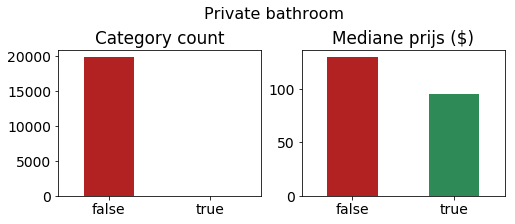


P-value is 6.28e-01
There are 19865 without Private bathroom, with a median price of 130.0
There are 2 with Private bathroom, with a median price of 95.0



P-value is 6.23e-08
There are 19463 without Stair gates, with a median price of 130.0
There are 404 with Stair gates, with a median price of 190.0
Effect is significant!



P-value is 8.07e-21
There are 16707 without Luggage dropoff allowed, with a median price of 130.0
There are 3160 with Luggage dropoff allowed, with a median price of 150.0
Effect is significant!


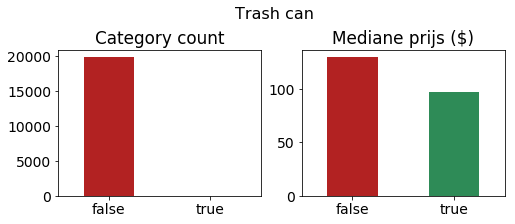


P-value is 4.77e-01
There are 19855 without Trash can, with a median price of 130.0
There are 12 with Trash can, with a median price of 97.5


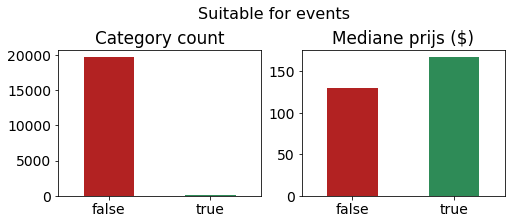


P-value is 3.21e-45
There are 19685 without Suitable for events, with a median price of 130.0
There are 182 with Suitable for events, with a median price of 167.5
Effect is significant!


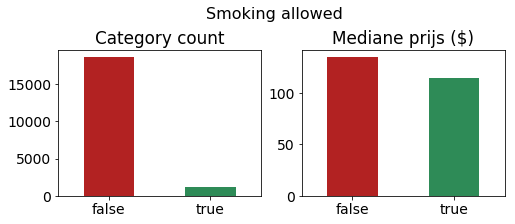


P-value is 2.00e-01
There are 18624 without Smoking allowed, with a median price of 135.0
There are 1243 with Smoking allowed, with a median price of 115.0


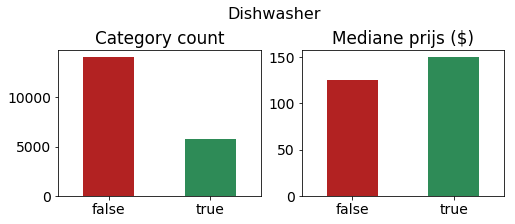


P-value is 1.17e-23
There are 14087 without Dishwasher, with a median price of 125.0
There are 5780 with Dishwasher, with a median price of 150.0
Effect is significant!


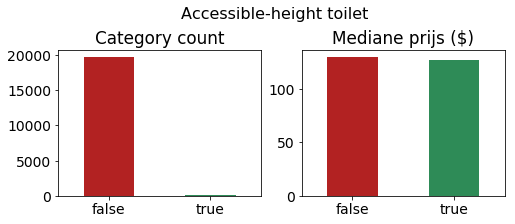


P-value is 4.97e-01
There are 19745 without Accessible-height toilet, with a median price of 130.0
There are 122 with Accessible-height toilet, with a median price of 127.5


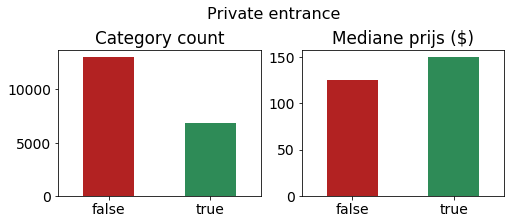


P-value is 1.17e-31
There are 13051 without Private entrance, with a median price of 125.0
There are 6816 with Private entrance, with a median price of 150.0
Effect is significant!



P-value is 3.06e-01
There are 19851 without Bathtub with bath chair, with a median price of 130.0
There are 16 with Bathtub with bath chair, with a median price of 140.0


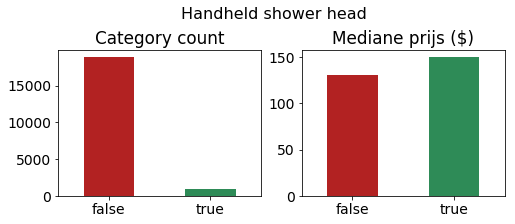


P-value is 1.64e-05
There are 18895 without Handheld shower head, with a median price of 130.0
There are 972 with Handheld shower head, with a median price of 150.0
Effect is significant!


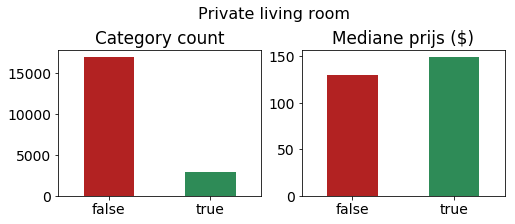


P-value is 3.87e-05
There are 16970 without Private living room, with a median price of 130.0
There are 2897 with Private living room, with a median price of 149.0
Effect is significant!


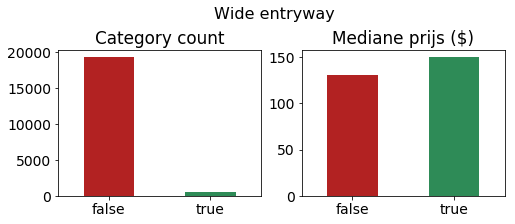


P-value is 2.80e-03
There are 19322 without Wide entryway, with a median price of 130.0
There are 545 with Wide entryway, with a median price of 150.0



P-value is    nan
There are 19866 without Roll-in shower with chair, with a median price of 130.0
There are 1 with Roll-in shower with chair, with a median price of 58.0


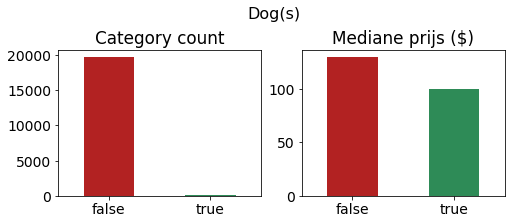


P-value is 4.66e-02
There are 19731 without Dog(s), with a median price of 130.0
There are 136 with Dog(s), with a median price of 100.0


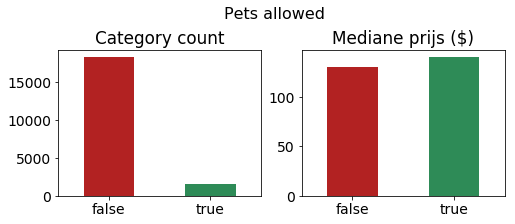


P-value is 4.15e-04
There are 18347 without Pets allowed, with a median price of 130.0
There are 1520 with Pets allowed, with a median price of 140.0
Effect is significant!



P-value is 7.10e-02
There are 19865 without Washer / Dryer, with a median price of 130.0
There are 2 with Washer / Dryer, with a median price of 417.5


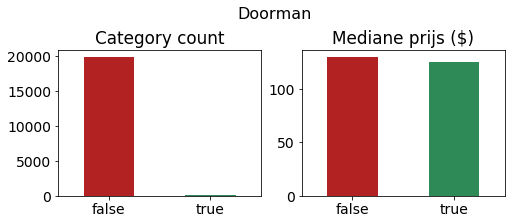


P-value is 5.77e-01
There are 19814 without Doorman, with a median price of 130.0
There are 53 with Doorman, with a median price of 125.0


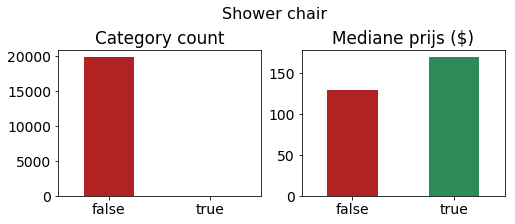


P-value is 3.84e-02
There are 19843 without Shower chair, with a median price of 130.0
There are 24 with Shower chair, with a median price of 170.0



P-value is 1.09e-08
There are 19361 without Hot tub, with a median price of 130.0
There are 506 with Hot tub, with a median price of 150.0
Effect is significant!



P-value is 3.84e-01
There are 14447 without Host greets you, with a median price of 130.0
There are 5420 with Host greets you, with a median price of 139.0


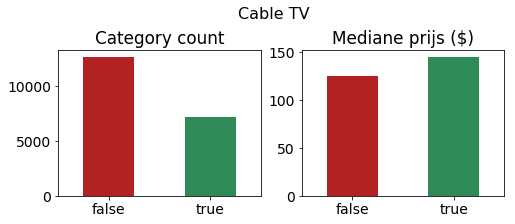


P-value is 1.43e-15
There are 12697 without Cable TV, with a median price of 125.0
There are 7170 with Cable TV, with a median price of 145.0
Effect is significant!


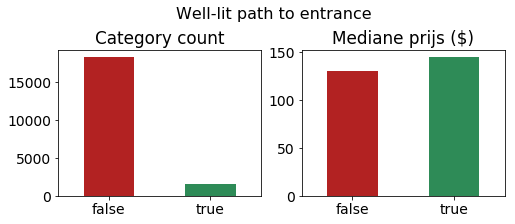


P-value is 9.43e-01
There are 18332 without Well-lit path to entrance, with a median price of 130.0
There are 1535 with Well-lit path to entrance, with a median price of 145.0


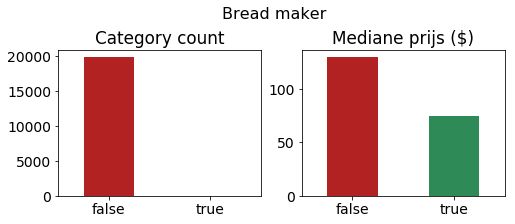


P-value is    nan
There are 19866 without Bread maker, with a median price of 130.0
There are 1 with Bread maker, with a median price of 75.0


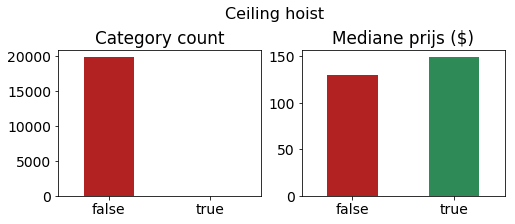


P-value is 9.20e-01
There are 19865 without Ceiling hoist, with a median price of 130.0
There are 2 with Ceiling hoist, with a median price of 149.0


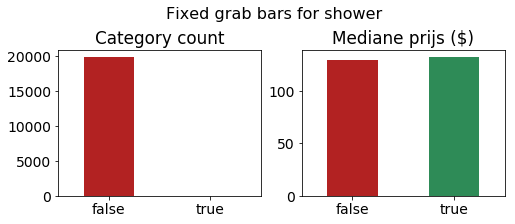


P-value is 6.76e-01
There are 19831 without Fixed grab bars for shower, with a median price of 130.0
There are 36 with Fixed grab bars for shower, with a median price of 132.5


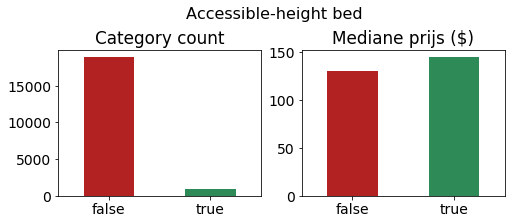


P-value is 1.53e-01
There are 18926 without Accessible-height bed, with a median price of 130.0
There are 941 with Accessible-height bed, with a median price of 145.0


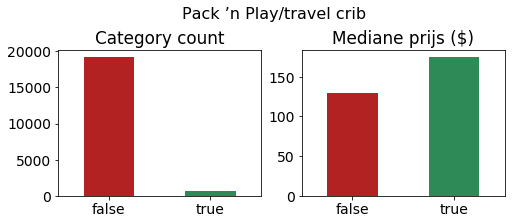


P-value is 2.48e-08
There are 19226 without Pack ’n Play/travel crib, with a median price of 130.0
There are 641 with Pack ’n Play/travel crib, with a median price of 175.0
Effect is significant!


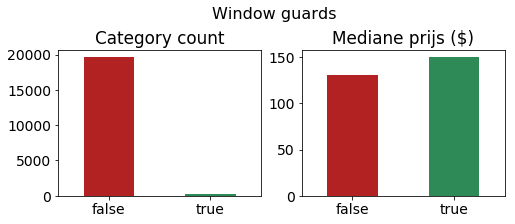


P-value is 1.38e-02
There are 19655 without Window guards, with a median price of 130.0
There are 212 with Window guards, with a median price of 150.0


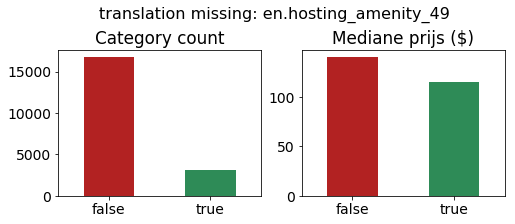


P-value is 2.06e-30
There are 16764 without translation missing: en.hosting_amenity_49, with a median price of 140.0
There are 3103 with translation missing: en.hosting_amenity_49, with a median price of 115.0
Effect is significant!


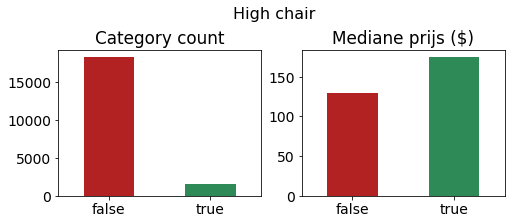


P-value is 6.68e-19
There are 18335 without High chair, with a median price of 130.0
There are 1532 with High chair, with a median price of 175.0
Effect is significant!


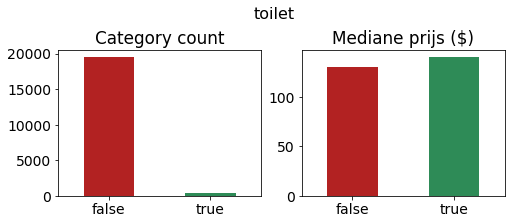


P-value is 2.42e-01
There are 19518 without toilet, with a median price of 130.0
There are 349 with toilet, with a median price of 140.0


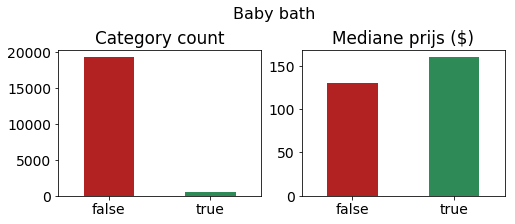


P-value is 9.04e-05
There are 19311 without Baby bath, with a median price of 130.0
There are 556 with Baby bath, with a median price of 160.0
Effect is significant!


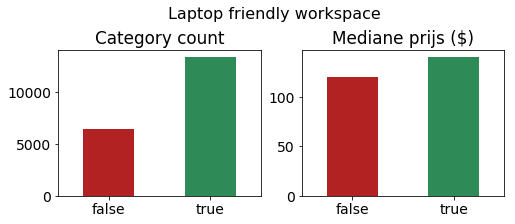


P-value is 2.93e-06
There are 6471 without Laptop friendly workspace, with a median price of 120.0
There are 13396 with Laptop friendly workspace, with a median price of 140.0
Effect is significant!


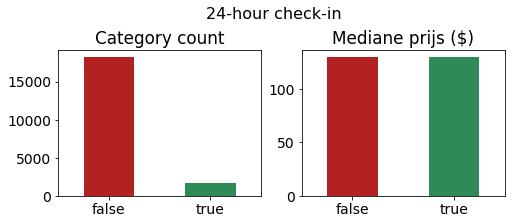


P-value is 2.18e-01
There are 18233 without 24-hour check-in, with a median price of 130.0
There are 1634 with 24-hour check-in, with a median price of 130.0



P-value is 2.09e-07
There are 19601 without Baby monitor, with a median price of 130.0
There are 266 with Baby monitor, with a median price of 180.0
Effect is significant!


In [36]:
# Plot counts, median price and calculate t-test P-value for every amenity
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
result = [binary_count_and_price_plot(col) for col in df.iloc[:,44:-1].columns]

In [37]:
import math
cleanpvalues = {}
allpvalues = dict(zip(df.iloc[:,44:-1].columns.values, result))
#type(allpvalues)
for key in allpvalues:
    #print(key)
    #print(allpvalues[key])
    if math.isnan(allpvalues[key]):
        print("nan found for: ", key)
    else:
        #print("nan found")
        cleanpvalues[key] = allpvalues[key]

nan found for:  Full kitchen
nan found for:  Pool with pool hoist
nan found for:  Roll-in shower with chair
nan found for:  Bread maker


P-values of effects of each amanity on price can be visualized using the 'Manhattan-plot' approach: taking the minus log of the P-value:

In [38]:
# -log Pvalues and order
cleanpvalues.update({k: -1*np.log(v) for k, v in cleanpvalues.items()})
ordereddict = OrderedDict(sorted(cleanpvalues.items(), key=lambda t: t[1]))

In [39]:
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 12, 30
plt.barh(list(ordereddict.keys()), list(ordereddict.values()),color='g', height=0.6)
plt.show()

Of the Airbnb hosts that are still listing on the site, the first joined on 24 September 2008, and the most recent joined on 06 December 2019.


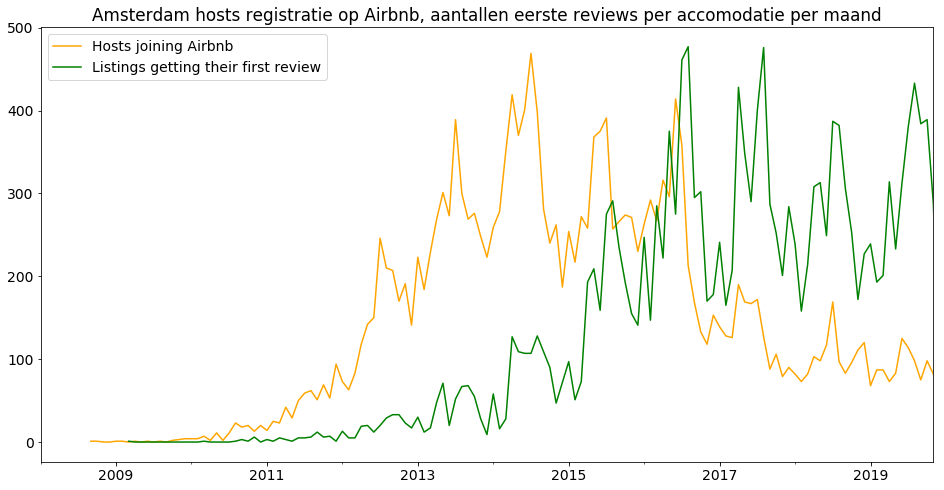

In [40]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 16, 8

print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")


df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('Amsterdam hosts registratie op Airbnb, aantallen eerste reviews per accomodatie per maand')
plt.legend()
plt.xlim('2008-01-01', '2019-11-30') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

# Time Series Analysis

In [41]:

# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 50, 70
decompose_time_series(ts_host_since, title='Aantal registraties op Airbnb per maand')